### Import Libraries

In [1]:
from util_comp import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap
import time
import warnings

import xgboost


from sklearn.model_selection import train_test_split
# from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.linear_model import LinearRegression

# Makes sure we see all columns
pd.set_option('display.max_columns', None)

# ignore warnings
warnings.filterwarnings('ignore')

### Load the data

In [2]:
df = pd.DataFrame(main(retained=True))
print(df.shape)
df.head()

Only retained columns are used
Shape of data: (44535, 72)
Elapsed time to compute age categorisation: 0 minutes and 0 seconds
Elapsed time to compute load column names: 0 minutes and 0 seconds
Elapsed time to compute clean data: 0 minutes and 0 seconds
Elapsed time to compute categorisation of outcome column: 0 minutes and 3 seconds
Dropped rows with missing values
Elapsed time to compute change values in catagorical columns: 1 minutes and 8 seconds
Elapsed time to compute Full process: 1 minutes and 11 seconds
(23239, 67)


Gender  Age  Work type  sector  size of business  \
0       1    1          2       7                 0   
1       1    4          2       4                 3   
2       0    0          0       5                 3   
3       0    0          3       1                 0   
4       0    4          0       6                 0   

   No of 3 to 6 years old children  No of 7 to 12 years old children  \
0                              0.0                               0.0   
1                              0.0                               0.0   
2                              0.0                               0.0   
3                              1.0                               0.0   
4                              0.0                               0.0   

   No of 13 to 17 years old children  No of 18 years and over children  \
0                                0.0                               0.0   
1                                0.0                               3.0   
2                                0.0                               0.0   
3                                0.0                               0.0   
4                                0.0                               0.0   

   dependents  Full Time/Part Time  shift work with alternating hours  \
0           2                    0                                  1   
1           1                    0                                  0   
2           2                    0                                  1   
3           2                    0                                  1   
4           0                    0                                  1   

   Place of work  standing or in an awkward posture  \
0              0                                  2   
1              2                                  3   
2              2                                  3   
3              6                                  0   
4              4                                  0   

   carry or move heavy loads  perform repetitive gestures  work on screen  \
0                          1                            0               0   
1                          3                            0               0   
2                          3                            3               0   
3                          0                            0               2   
4                          1                            1               0   

   cold/ hot env  work in noisy env  breathe toxic products or dust  \
0              3                  1                               1   
1              1                  0                               1   
2              3                  1                               1   
3              0                  1                               0   
4              3                  3                               0   

   handle toxic or dangerous products  risk of serious fall  \
0                                   1                     1   
1                                   1                     1   
2                                   1                     1   
3                                   0                     1   
4                                   0                     1   

   machinery with exposure to injury  learn new things  \
0                                  1                 1   
1                                  1                 2   
2                                  1                 1   
3                                  0                 2   
4                                  1                 0   

   work quickly or very intensely  long periods of concentration  \
0                               1                              0   
1                               2                              0   
2                               1                              1   
3                               1                              2   
4                               0                              1  

## Training of the data


#### split data to train and test sets

In [3]:
data = df.copy()

# Split the data for training and evaluation

X = data.drop('outcome', axis=1, inplace=False)
y = data['outcome']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)


#### Train the Random Forest model

In [4]:
# Fit RF (blackbox) model
t1 = time.time()
sl = RandomForestClassifier(class_weight='balanced_subsample', n_estimators=100, random_state=42)
sl.fit(X_train, y_train)
t2 = time.time()
print(time_e(t1, t2, "fitting RF model"))

Elapsed time to compute fitting RF model: 0 minutes and 2 seconds


In [5]:
y_pred = sl.predict(X_test)
y_pred_proba = sl.predict_proba(X_test)

In [6]:
y_test

11456    0
1288     3
5535     3
12657    1
8603     0
        ..
15713    3
3323     2
13912    0
4991     1
16073    0
Name: outcome, Length: 4648, dtype: int8

In [7]:
y_pred_proba

array([[0.66, 0.19, 0.06, 0.09],
       [0.68, 0.15, 0.08, 0.09],
       [0.72, 0.1 , 0.08, 0.1 ],
       ...,
       [0.51, 0.16, 0.17, 0.16],
       [0.62, 0.2 , 0.11, 0.07],
       [0.42, 0.19, 0.08, 0.31]])

In [8]:
print(f"F1 Score: {f1_score(y_test, y_pred, average='macro')}")
print(f"Accuracy of test: {accuracy_score(y_test, y_pred)}")
print(f"Accuracy of train: {accuracy_score(y_train, sl.predict(X_train))}")

# ROAUC

print(f"ROAUC: {roc_auc_score(y_test, y_pred_proba, multi_class='ovr')}")
print(f"Confusin matrix: \n{confusion_matrix(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

F1 Score: 0.27598574826543626
Accuracy of test: 0.6817986230636833
Accuracy of train: 1.0
ROAUC: 0.6998508781948221
Confusin matrix: 
[[3068    1    0   28]
 [ 523   18    0    9]
 [ 354    0    5   12]
 [ 551    1    0   78]]
              precision    recall  f1-score   support

           0       0.68      0.99      0.81      3097
           1       0.90      0.03      0.06       550
           2       1.00      0.01      0.03       371
           3       0.61      0.12      0.21       630

    accuracy                           0.68      4648
   macro avg       0.80      0.29      0.28      4648
weighted avg       0.72      0.68      0.58      4648



## Explanantion using SHAP

In [9]:
explainer = shap.TreeExplainer(sl)

# Calculate shapley values for test data
start_index = 0
end_index = 10

# time to run 10 samples
s_time = time.time()
shap_values = explainer.shap_values(X_test[start_index:end_index]) # 0 - 9
e_time = time.time()
time_e(s_time, e_time, f"Shapley values for test data[{start_index}:{end_index}]")
X_test[start_index:end_index]

Gender  Age  Work type  sector  size of business  \
11456       1    1          2       2                 1   
1288        0    4          0       7                 2   
5535        0    2          3       0                 3   
12657       1    0          2       4                 0   
8603        0    0          2       7                 3   
8828        1    0          0       5                 1   
16011       1    4          2       7                 0   
7779        0    2          2       7                 3   
8779        1    5          0       6                 3   
11941       0    0          0       5                 1   

       No of 3 to 6 years old children  No of 7 to 12 years old children  \
11456                              2.0                               0.0   
1288                               0.0                               0.0   
5535                               1.0                               0.0   
12657                              0.0                               0.0   
8603                               0.0                               0.0   
8828                               0.0                               0.0   
16011                              0.0                               0.0   
7779                               0.0                               0.0   
8779                               0.0                               0.0   
11941                              0.0                               1.0   

       No of 13 to 17 years old children  No of 18 years and over children  \
11456                                0.0                               0.0   
1288                                 0.0                               1.0   
5535                                 1.0                               0.0   
12657                                0.0                               0.0   
8603                                 0.0                               0.0   
8828                                 0.0                               0.0   
16011                                1.0                               0.0   
7779                                 0.0                               1.0   
8779                                 1.0                               1.0   
11941                                0.0                               0.0   

       dependents  Full Time/Part Time  shift work with alternating hours  \
11456           2                    0                                  1   
1288            2                    0                                  1   
5535            2                    0                                  1   
12657           2                    1                                  1   
8603            2                    0                                  1   
8828            2                    0                                  1   
16011           2                    1                                  1   
7779            2                    0                                  1   
8779            2                    0                                  1   
11941           2                    0                                  1   

       Place of work  standing or in an awkward posture  \
11456              1                                  3   
1288               0                                  2   
5535               3                                  0   
12657              1                                  2   
8603               0                                  3   
8828               1                                  2   
16011              8                                  0   
7779               1                                  2   
8779               0                                  3   
11941              1                                  2   

       carry or move heavy loads  perform repetitive gestures  work on screen  \
11456                          2                            1               0   
1

In [10]:
y_test[start_index:end_index]

11456    0
1288     3
5535     3
12657    1
8603     0
8828     0
16011    0
7779     2
8779     3
11941    0
Name: outcome, dtype: int8

### SHAP Values

In [11]:
print(shap_values.shape)

(10, 66, 4)


In [12]:
print(shap_values[0].shape)
shap_values

(66, 4)


array([[[-2.00180954e-03,  4.50906304e-04, -1.01550171e-03,
          2.56640495e-03],
        [-1.12219262e-02,  2.64947518e-02, -3.20142037e-03,
         -1.20714053e-02],
        [ 8.97101772e-03, -8.06038473e-03, -3.26801705e-03,
          2.35738406e-03],
        ...,
        [ 1.04248595e-02,  8.42189261e-04, -3.47927692e-03,
         -7.78777185e-03],
        [ 3.47699345e-03,  3.94110903e-03, -4.47673268e-03,
         -2.94136979e-03],
        [ 2.13695099e-03, -6.27037692e-04, -1.39055425e-04,
         -1.37085787e-03]],

       [[ 1.15336959e-02, -3.82022238e-03, -2.10159025e-03,
         -5.61188332e-03],
        [ 2.80270484e-02, -5.17757930e-02,  4.97773424e-03,
          1.87710103e-02],
        [ 5.02524014e-03,  9.91377806e-03, -4.02534135e-03,
         -1.09136768e-02],
        ...,
        [ 1.54456702e-02,  1.13564647e-03, -6.19945825e-03,
         -1.03818585e-02],
        [ 8.19839442e-03,  4.97468327e-03, -7.74138164e-03,
         -5.43169605e-03],
        [ 3.273

In [13]:
shap.initjs()
# Force plot
prediction = sl.predict(X_test[start_index:end_index])[0]
print(f"The sl predicted: {prediction}")
shap.force_plot(explainer.expected_value[1],
                shap_values[...,1],
                X_test[start_index:end_index])  # for values

The sl predicted: 0


### Summary of Variables that affected the prediction using SHAP

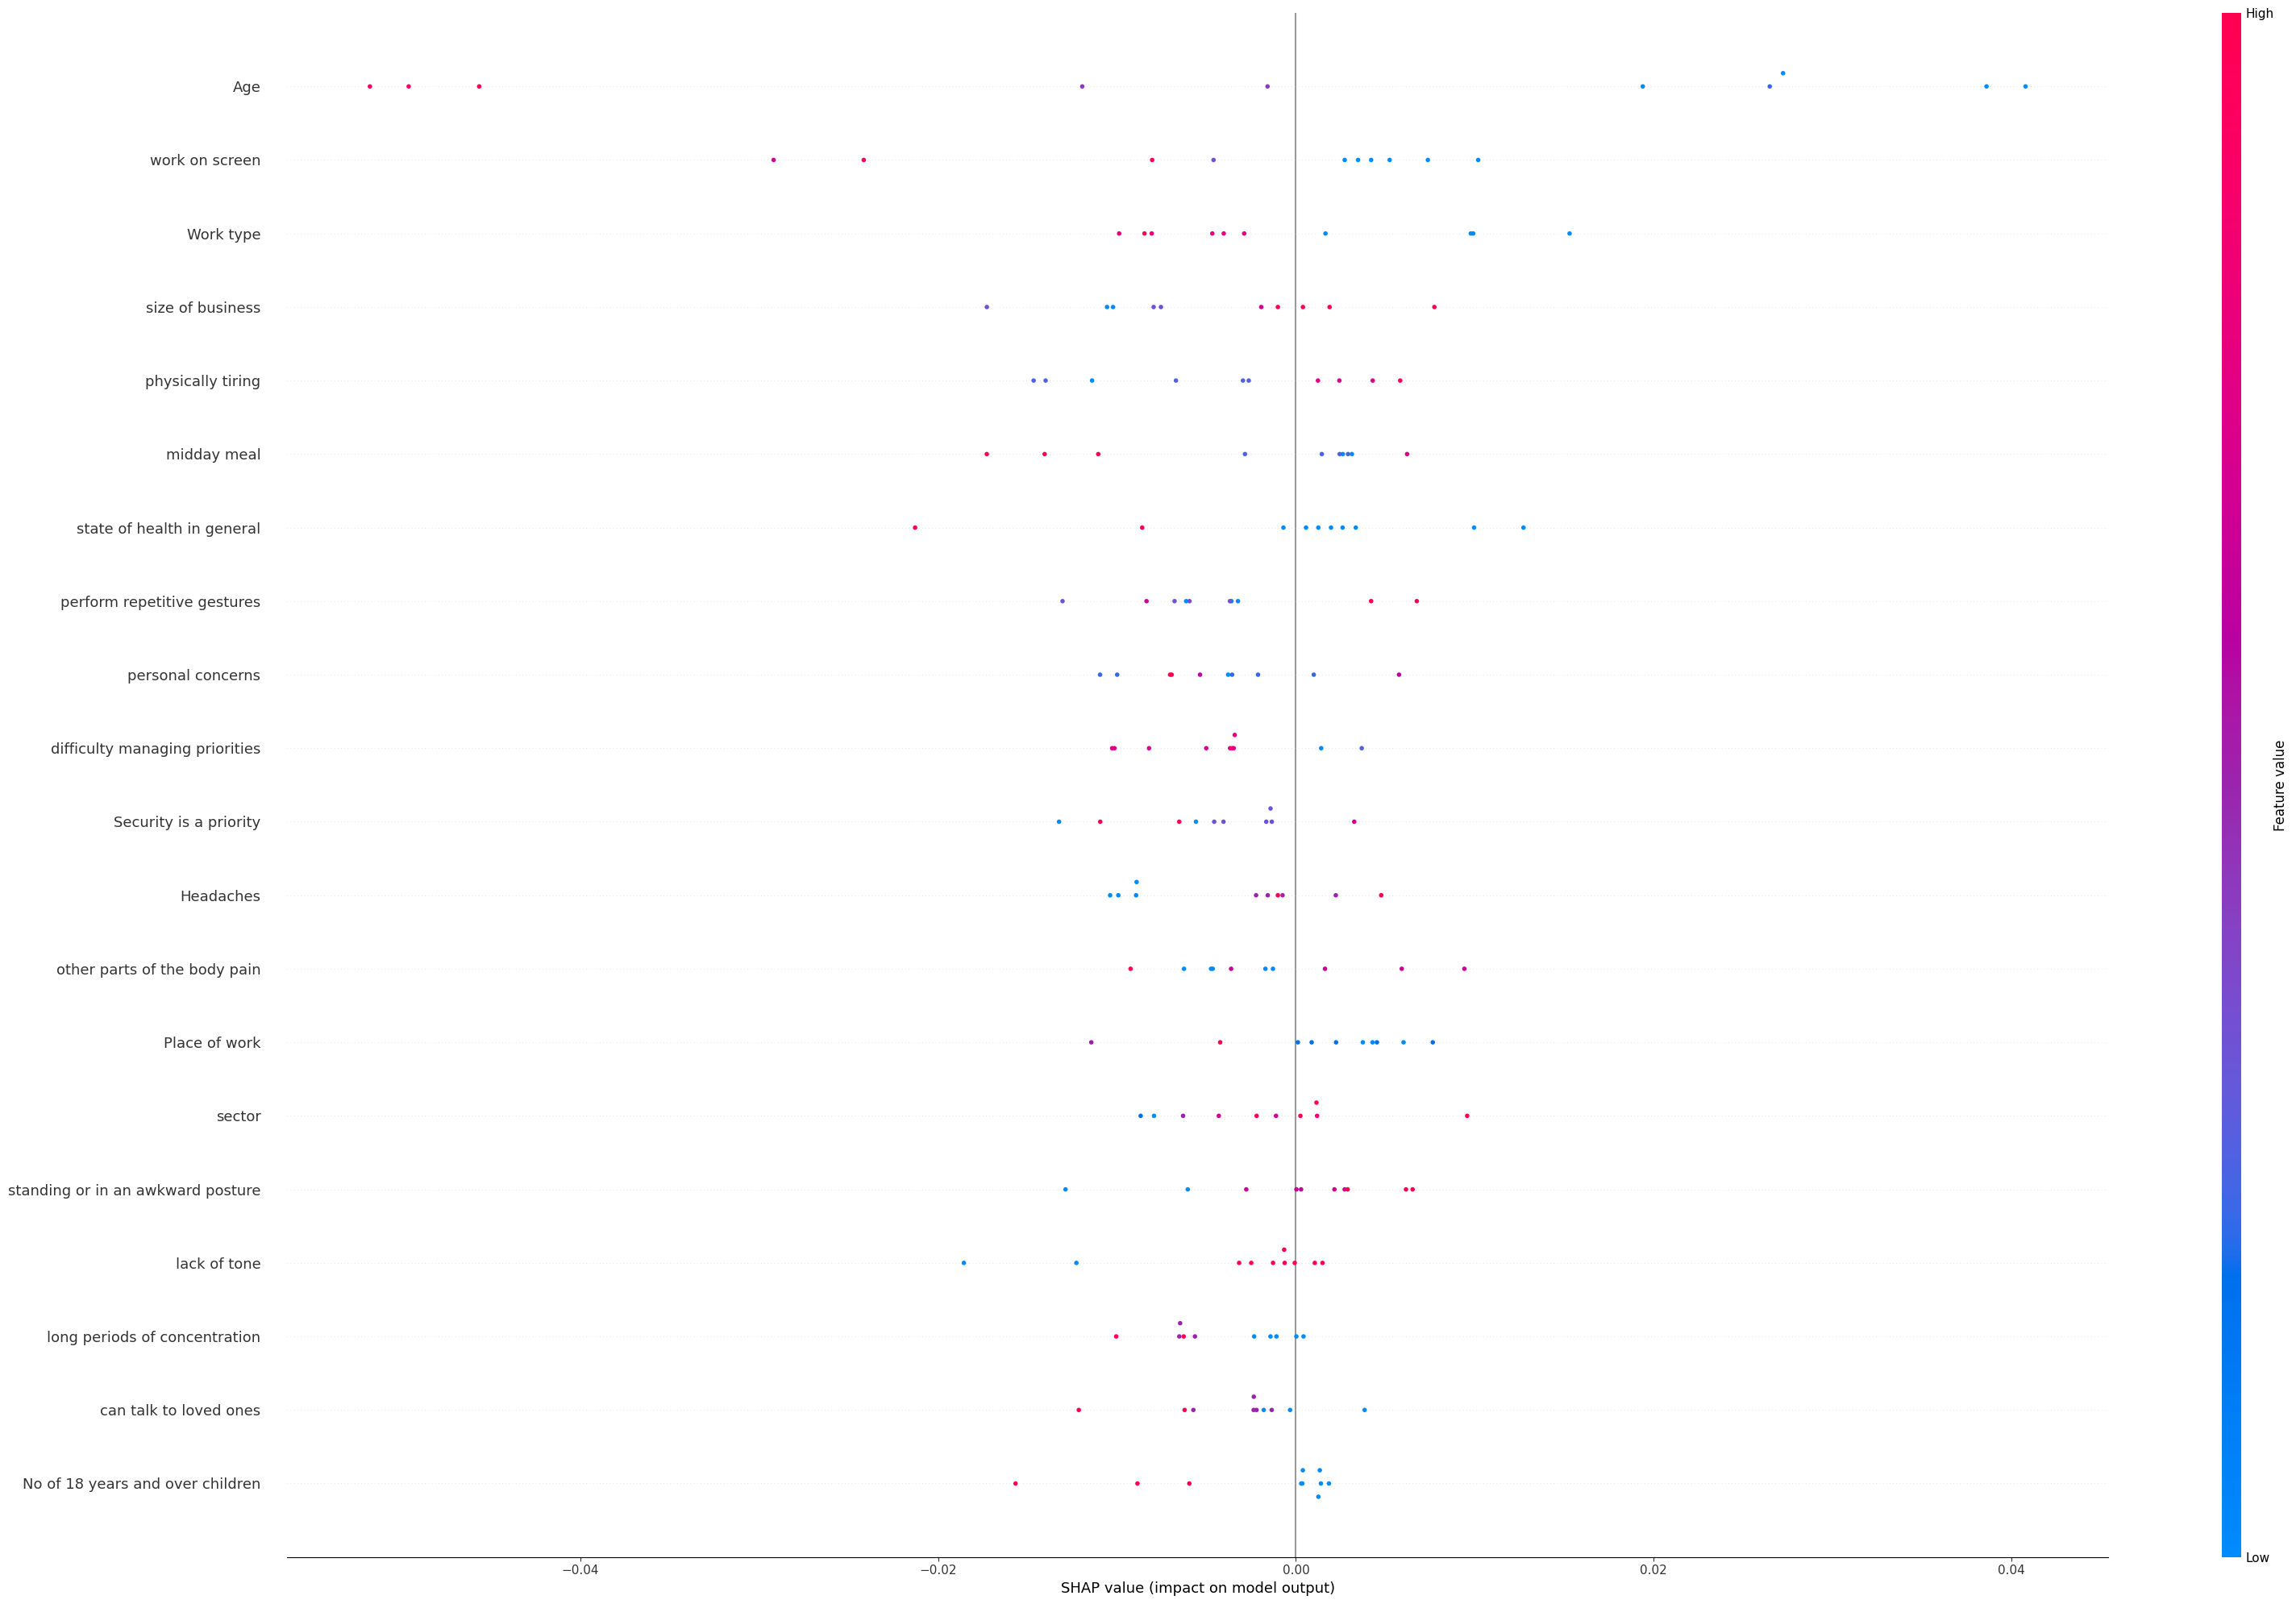

In [14]:
shap.summary_plot(shap_values[...,1], X_test[start_index:end_index], plot_size=(32,20), show=False)
plt.savefig('outputs/02_SHAP/summary_plot_for_10_samples.png', bbox_inches='tight')
plt.show()

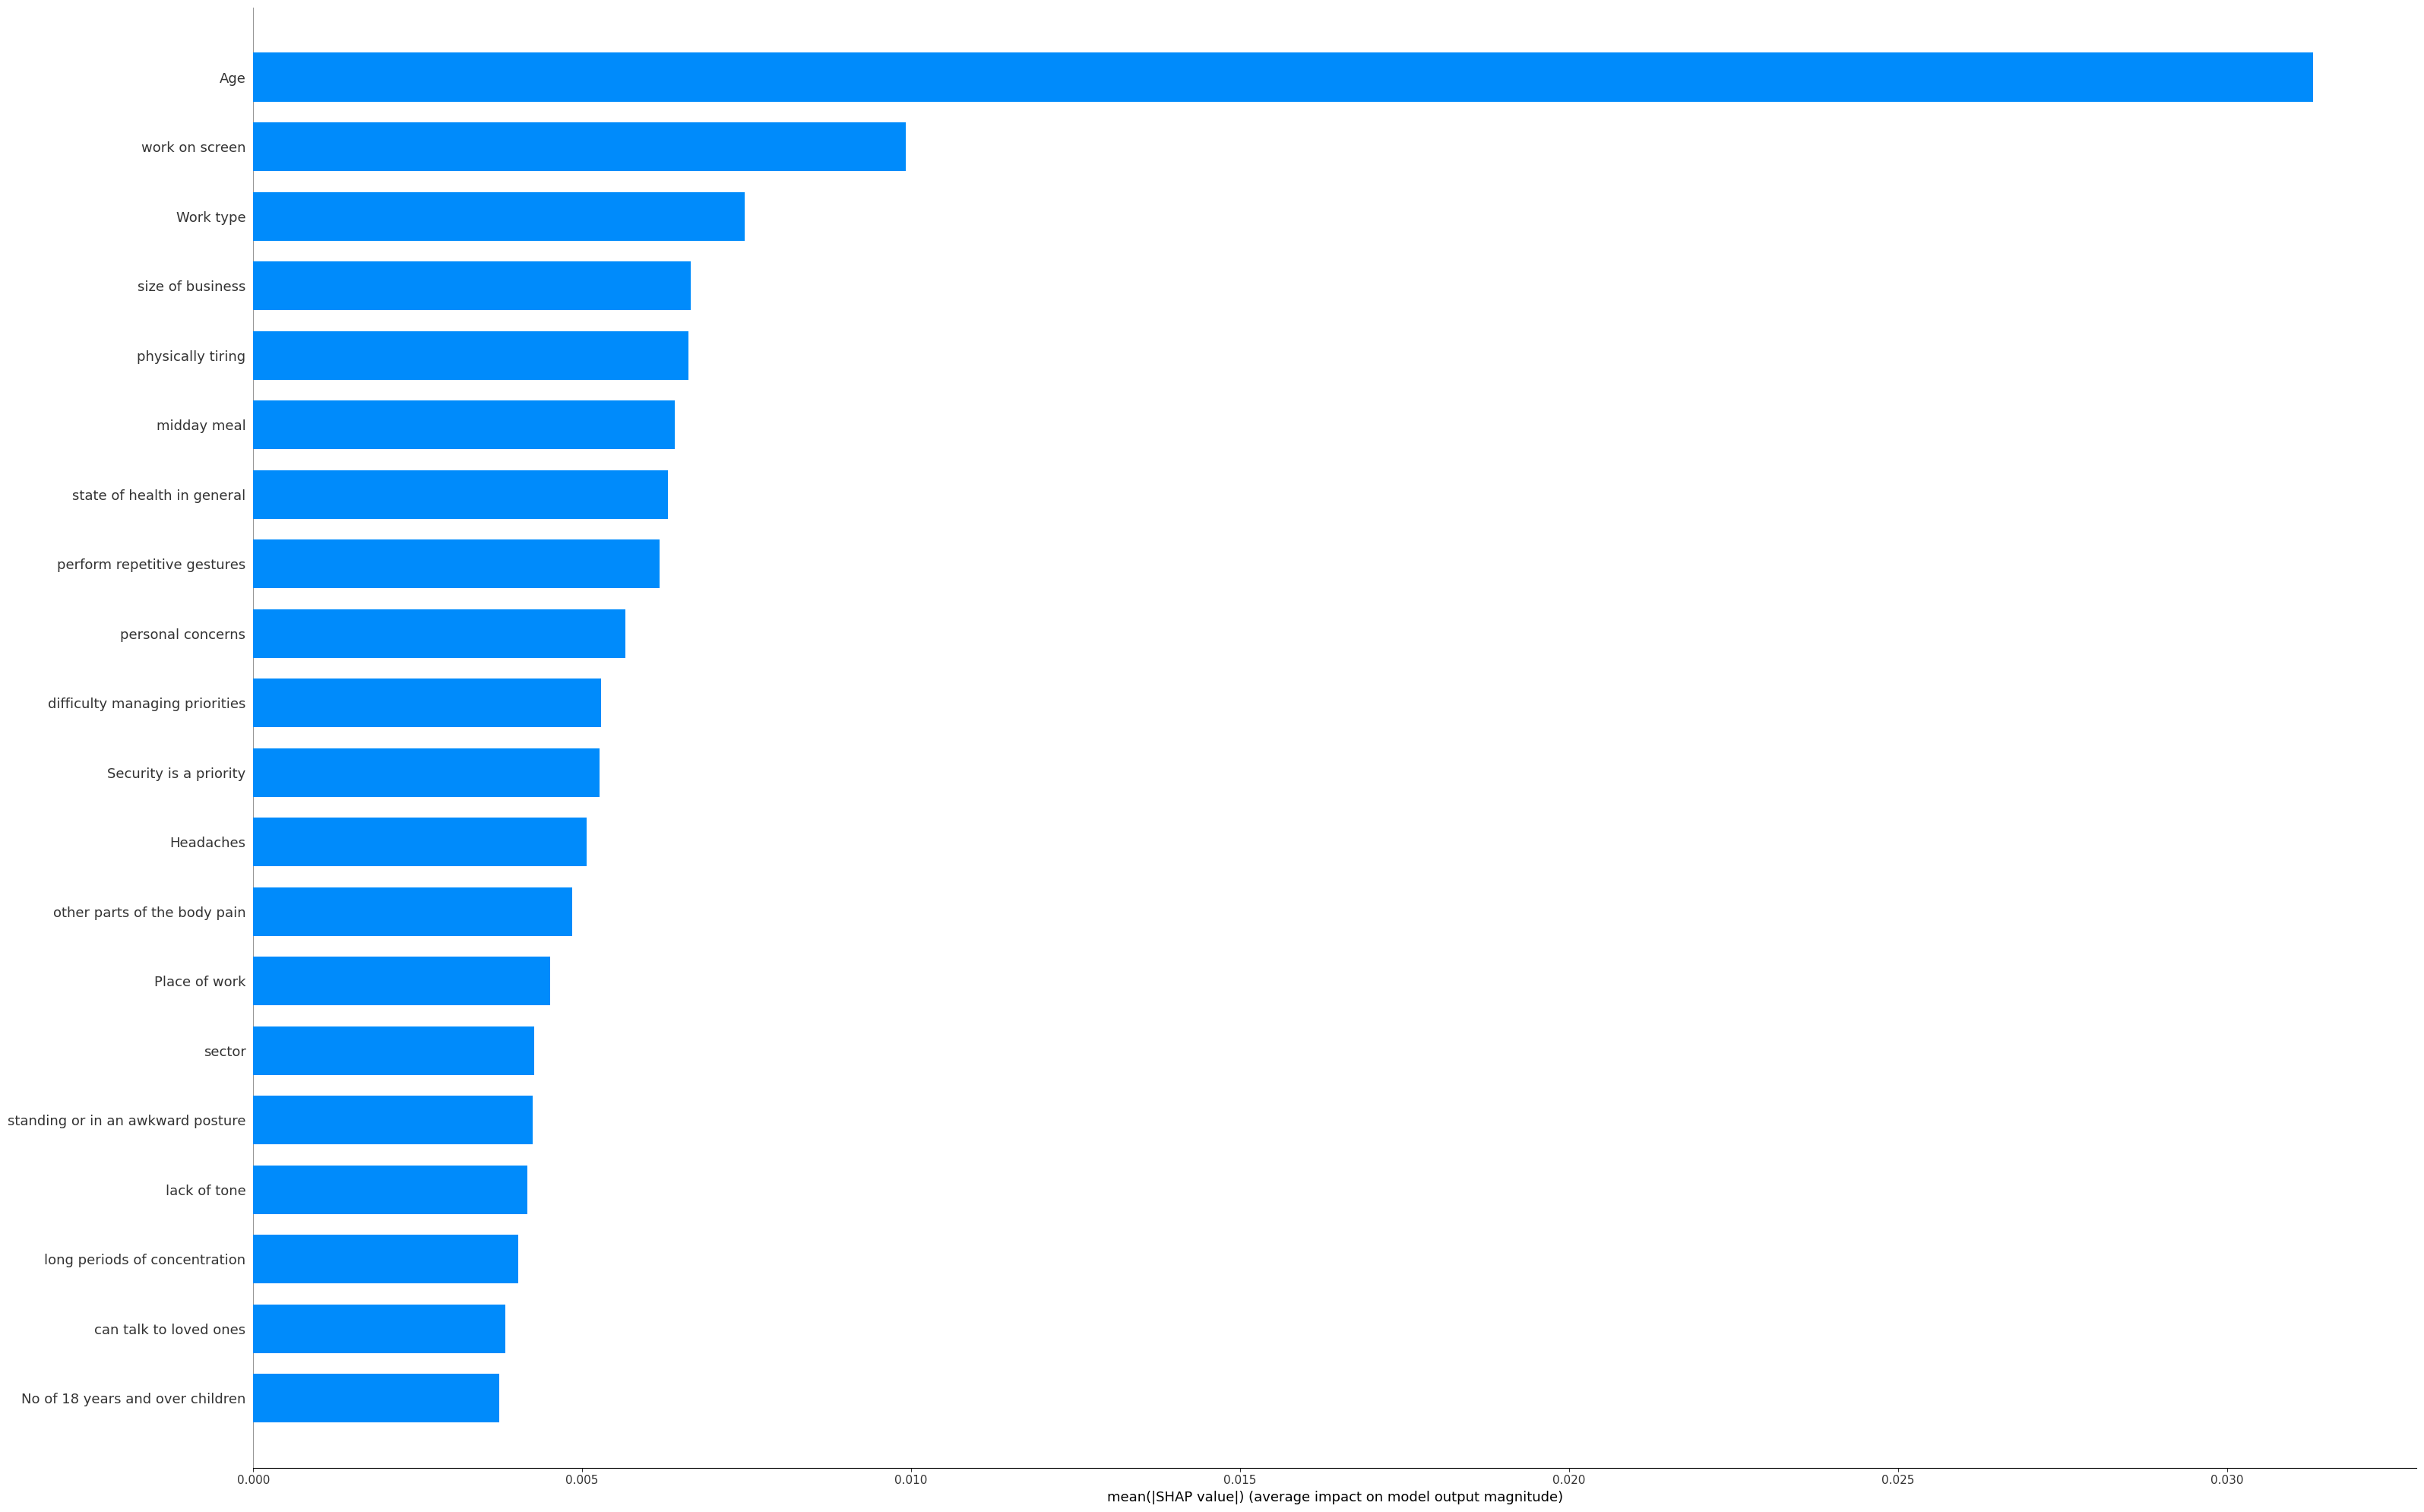

In [15]:
shap.summary_plot(shap_values[...,1], X_test[start_index:end_index], plot_type="bar", plot_size=(32,20), show=False)
plt.savefig('outputs/02_SHAP/summary_plot_bar_for_10_samples.png', bbox_inches='tight')
plt.show()

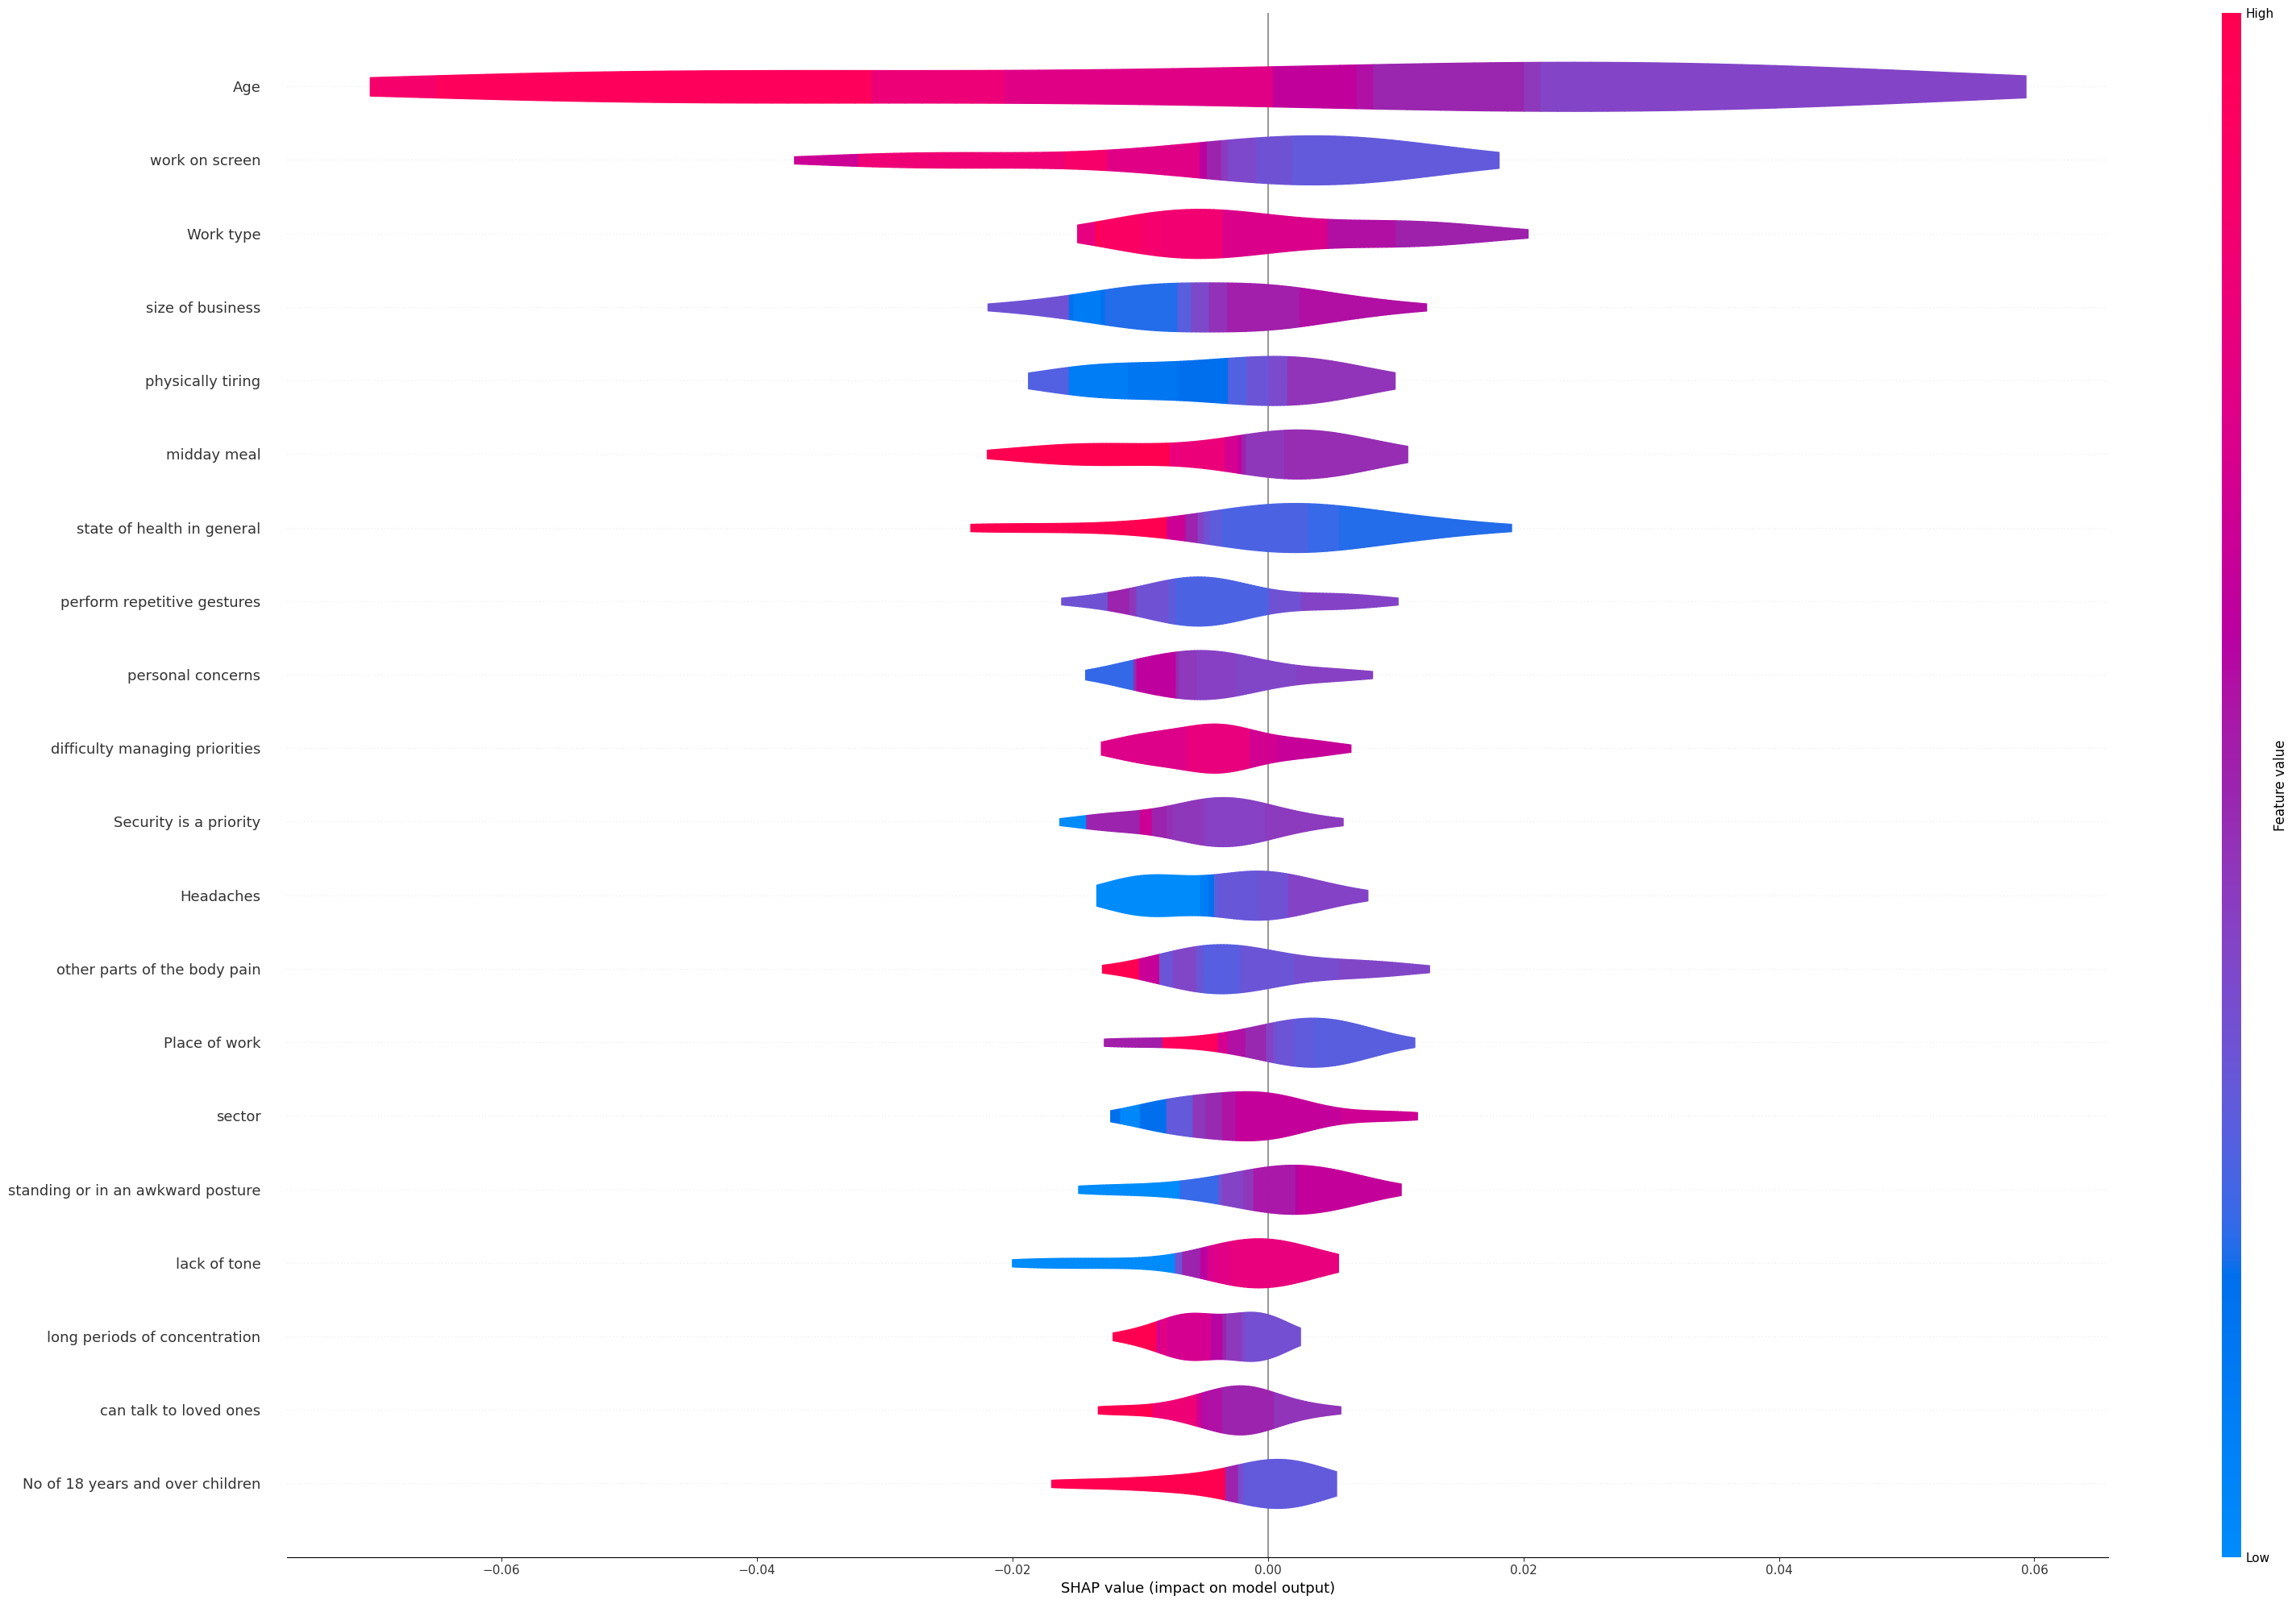

In [16]:
shap.summary_plot(shap_values[...,1], X_test[start_index:end_index], plot_type="violin", plot_size=(32,20), show=False)
plt.savefig('outputs/02_SHAP/summary_plot_violin_for_10_samples.png', bbox_inches='tight')
plt.show()

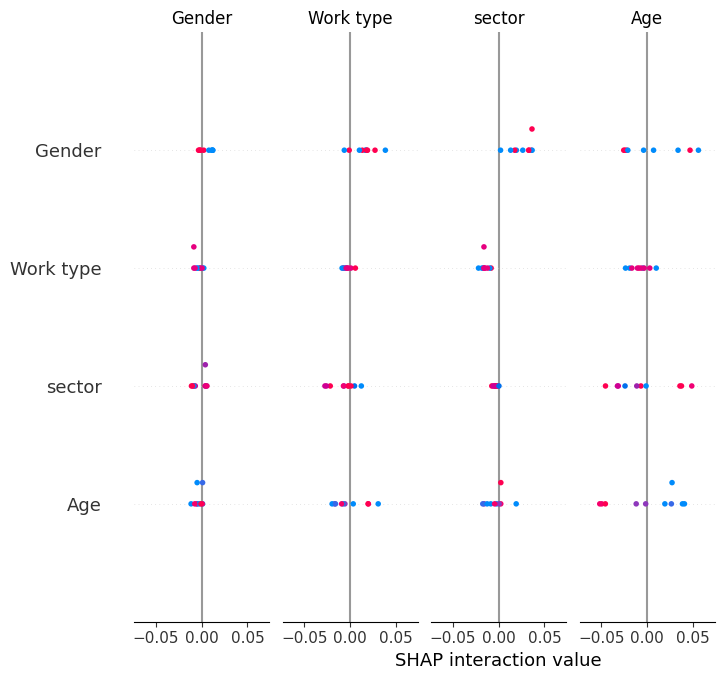

In [17]:
# Shap interaction values

shap.summary_plot(shap_values, X_test[start_index:end_index], plot_type="bar", plot_size=(18,12), show=False)
plt.savefig('outputs/02_SHAP/summary_plot_bar_interaction_for_10_samples.png', bbox_inches='tight')
plt.show()

In [18]:
# Calculate shapley values for all data
s_time = time.time()
shap_values_all = explainer.shap_values(X_test)
e_time = time.time()
print(time_e(s_time, e_time, "Shapley values for all data"))

Elapsed time to compute Shapley values for all data: 24 minutes and 52 seconds


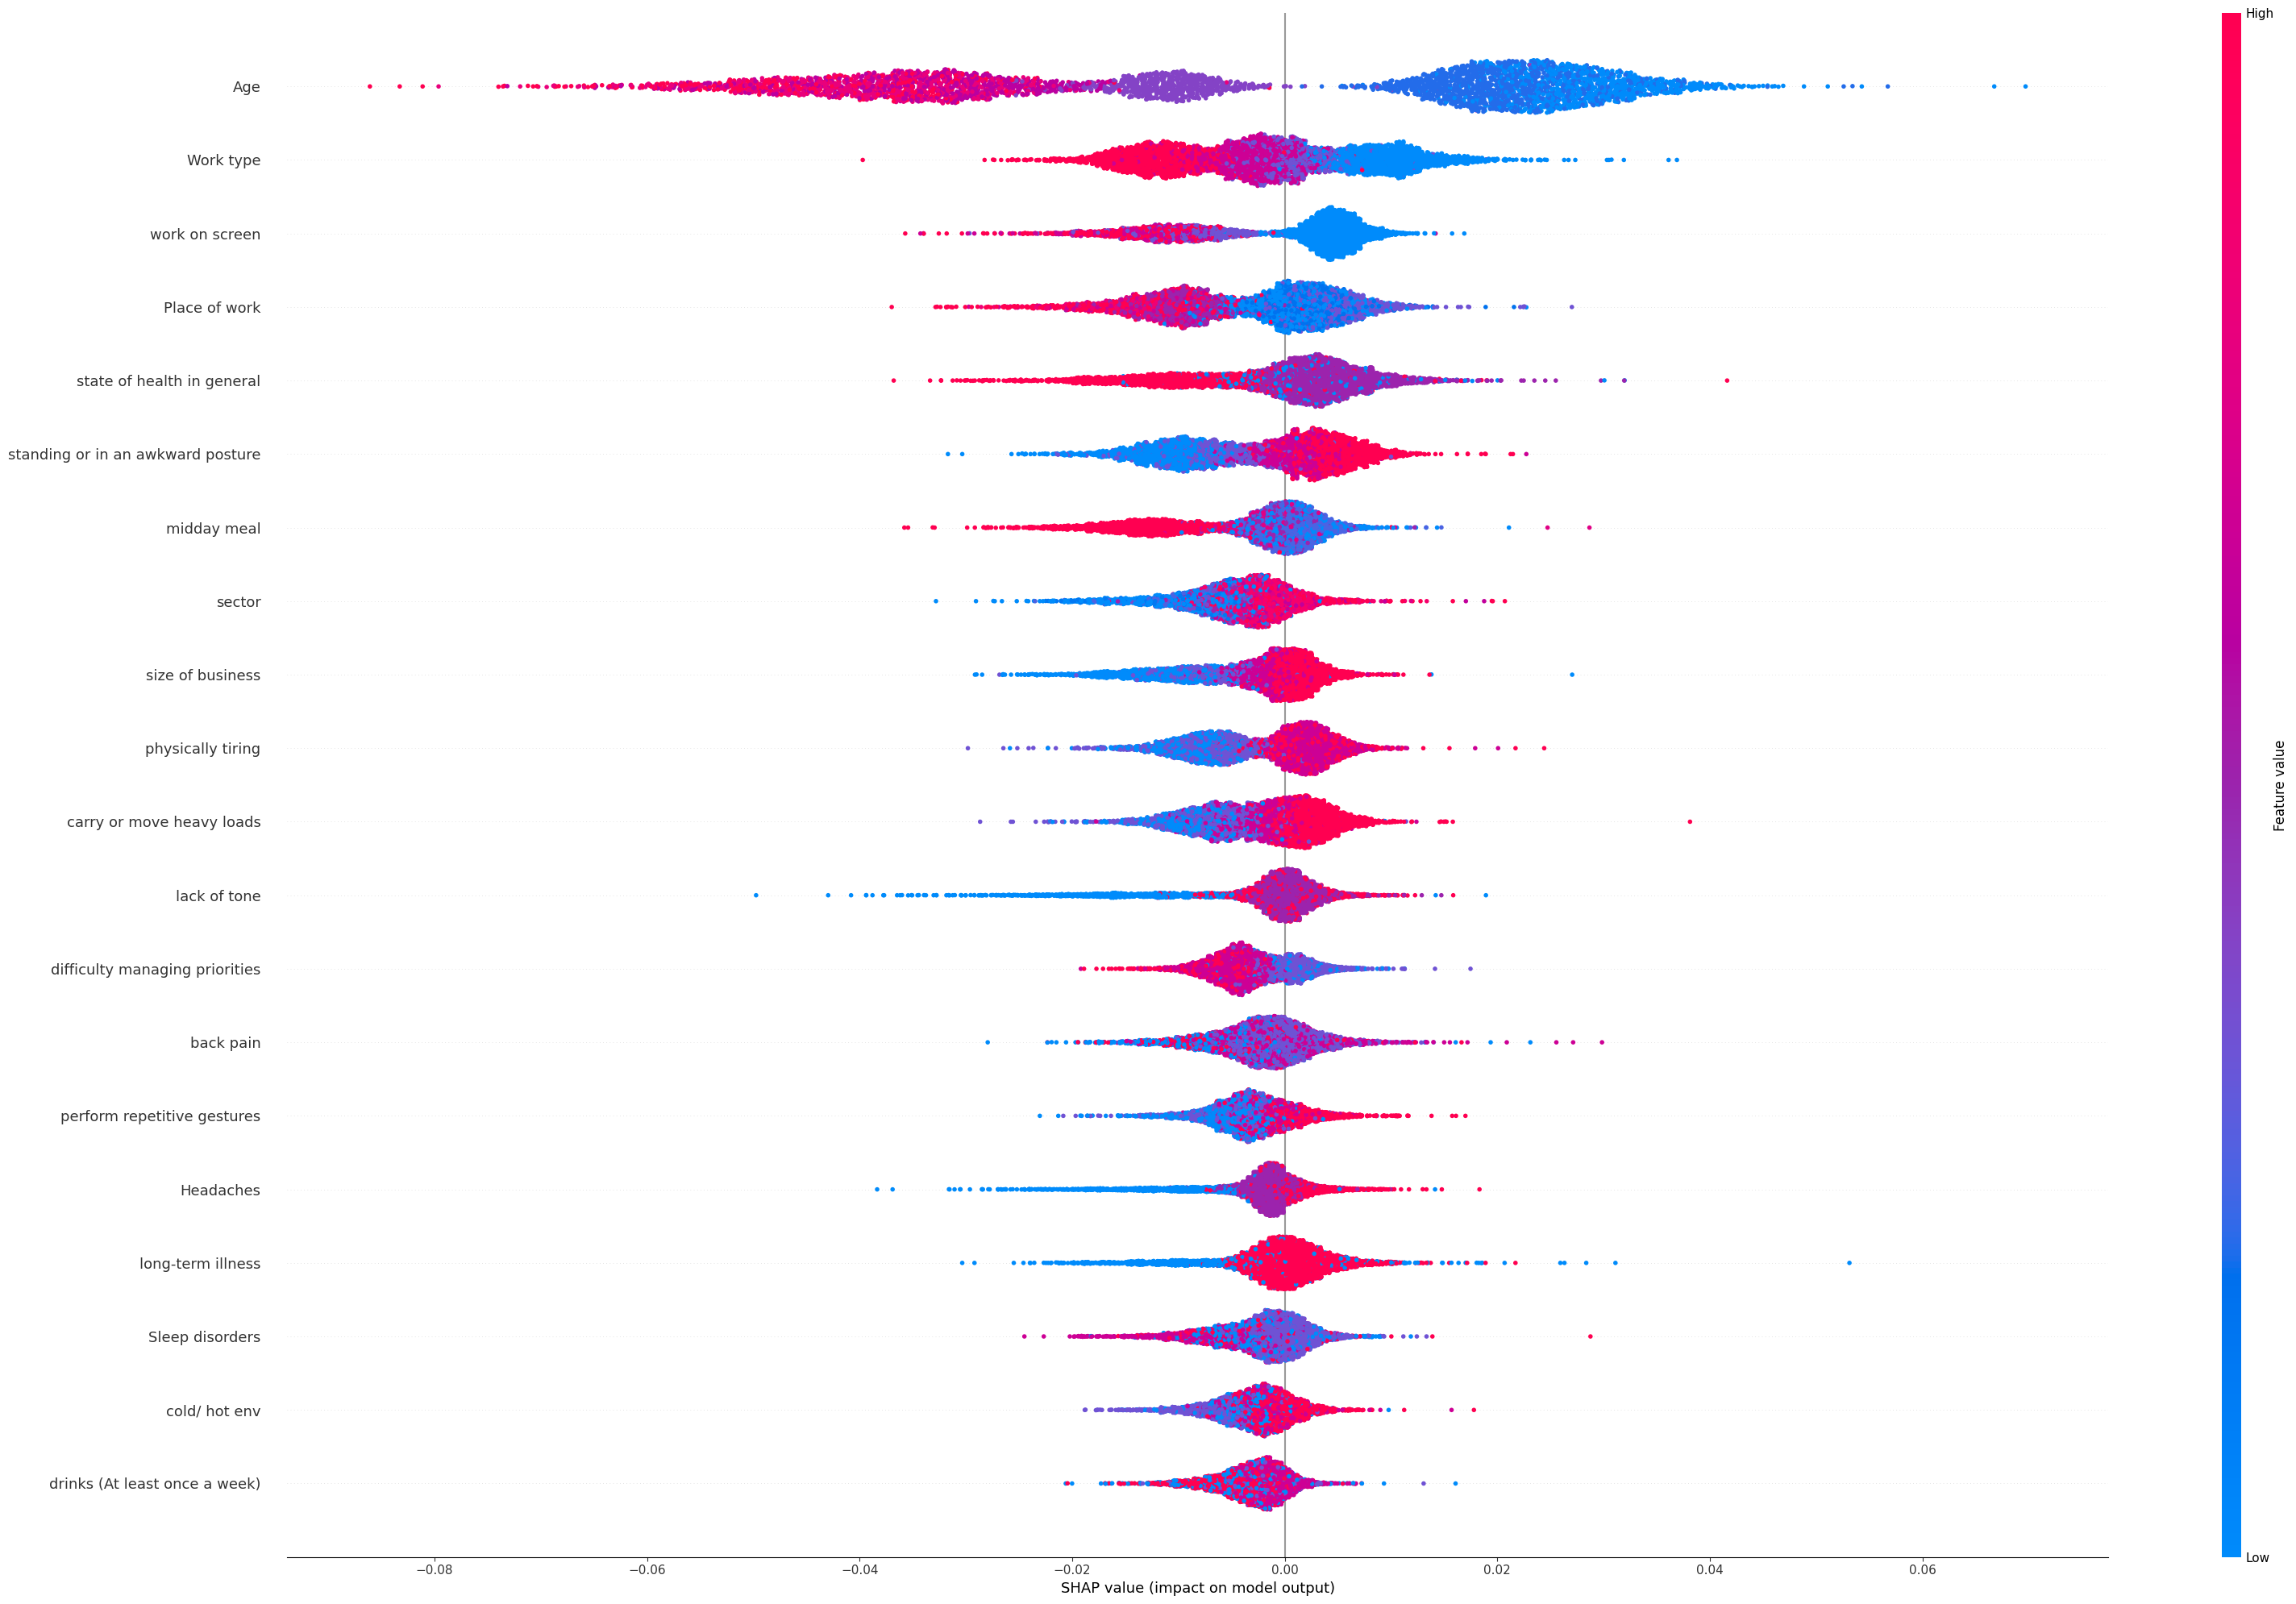

Elapsed time to compute Summary plot for all data: 0 minutes and 2 seconds


In [19]:
s_time = time.time()
shap.summary_plot(shap_values_all[...,1], X_test, plot_size=(32,20), show=False)
plt.savefig('outputs/02_SHAP/shap_summary_plot_all.png', bbox_inches='tight')
plt.show()
e_time = time.time()
print(time_e(s_time, e_time, "Summary plot for all data"))

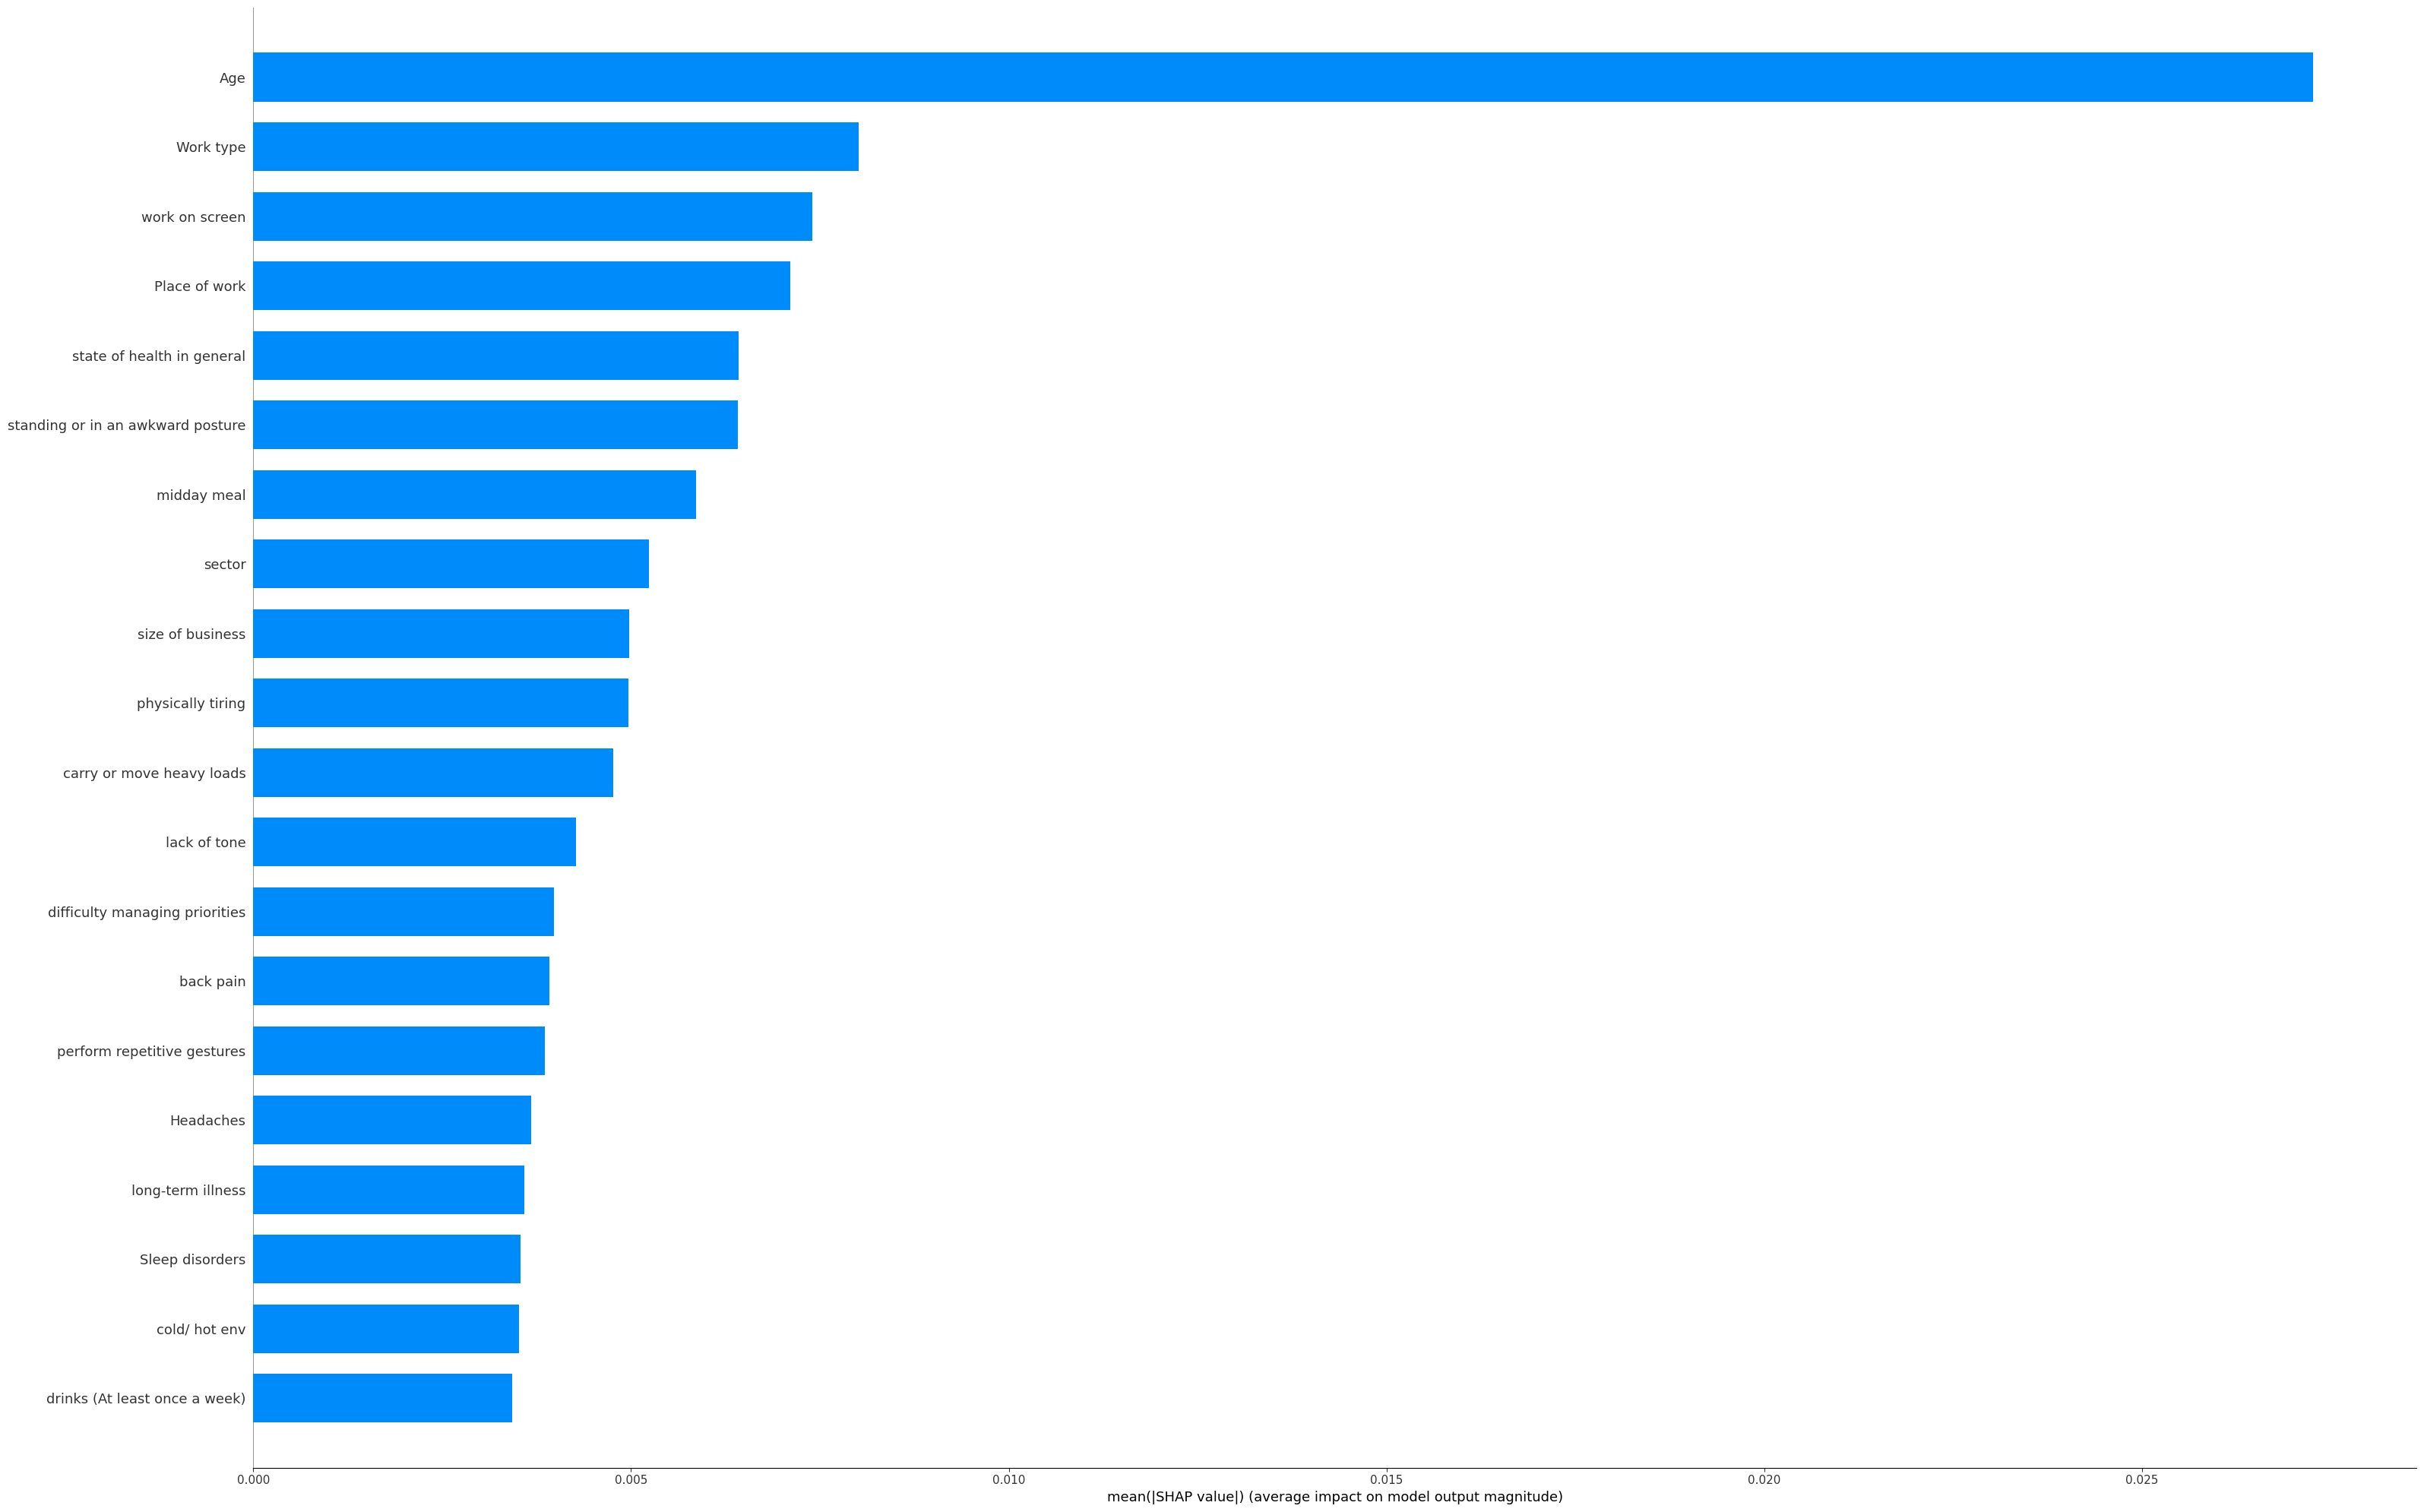

In [20]:
shap.summary_plot(shap_values_all[...,1], X_test, plot_type="bar", plot_size=(32,20), show=False)
plt.savefig('outputs/02_SHAP/shap_summary_plot_bar_all.png', bbox_inches='tight')
plt.show() 

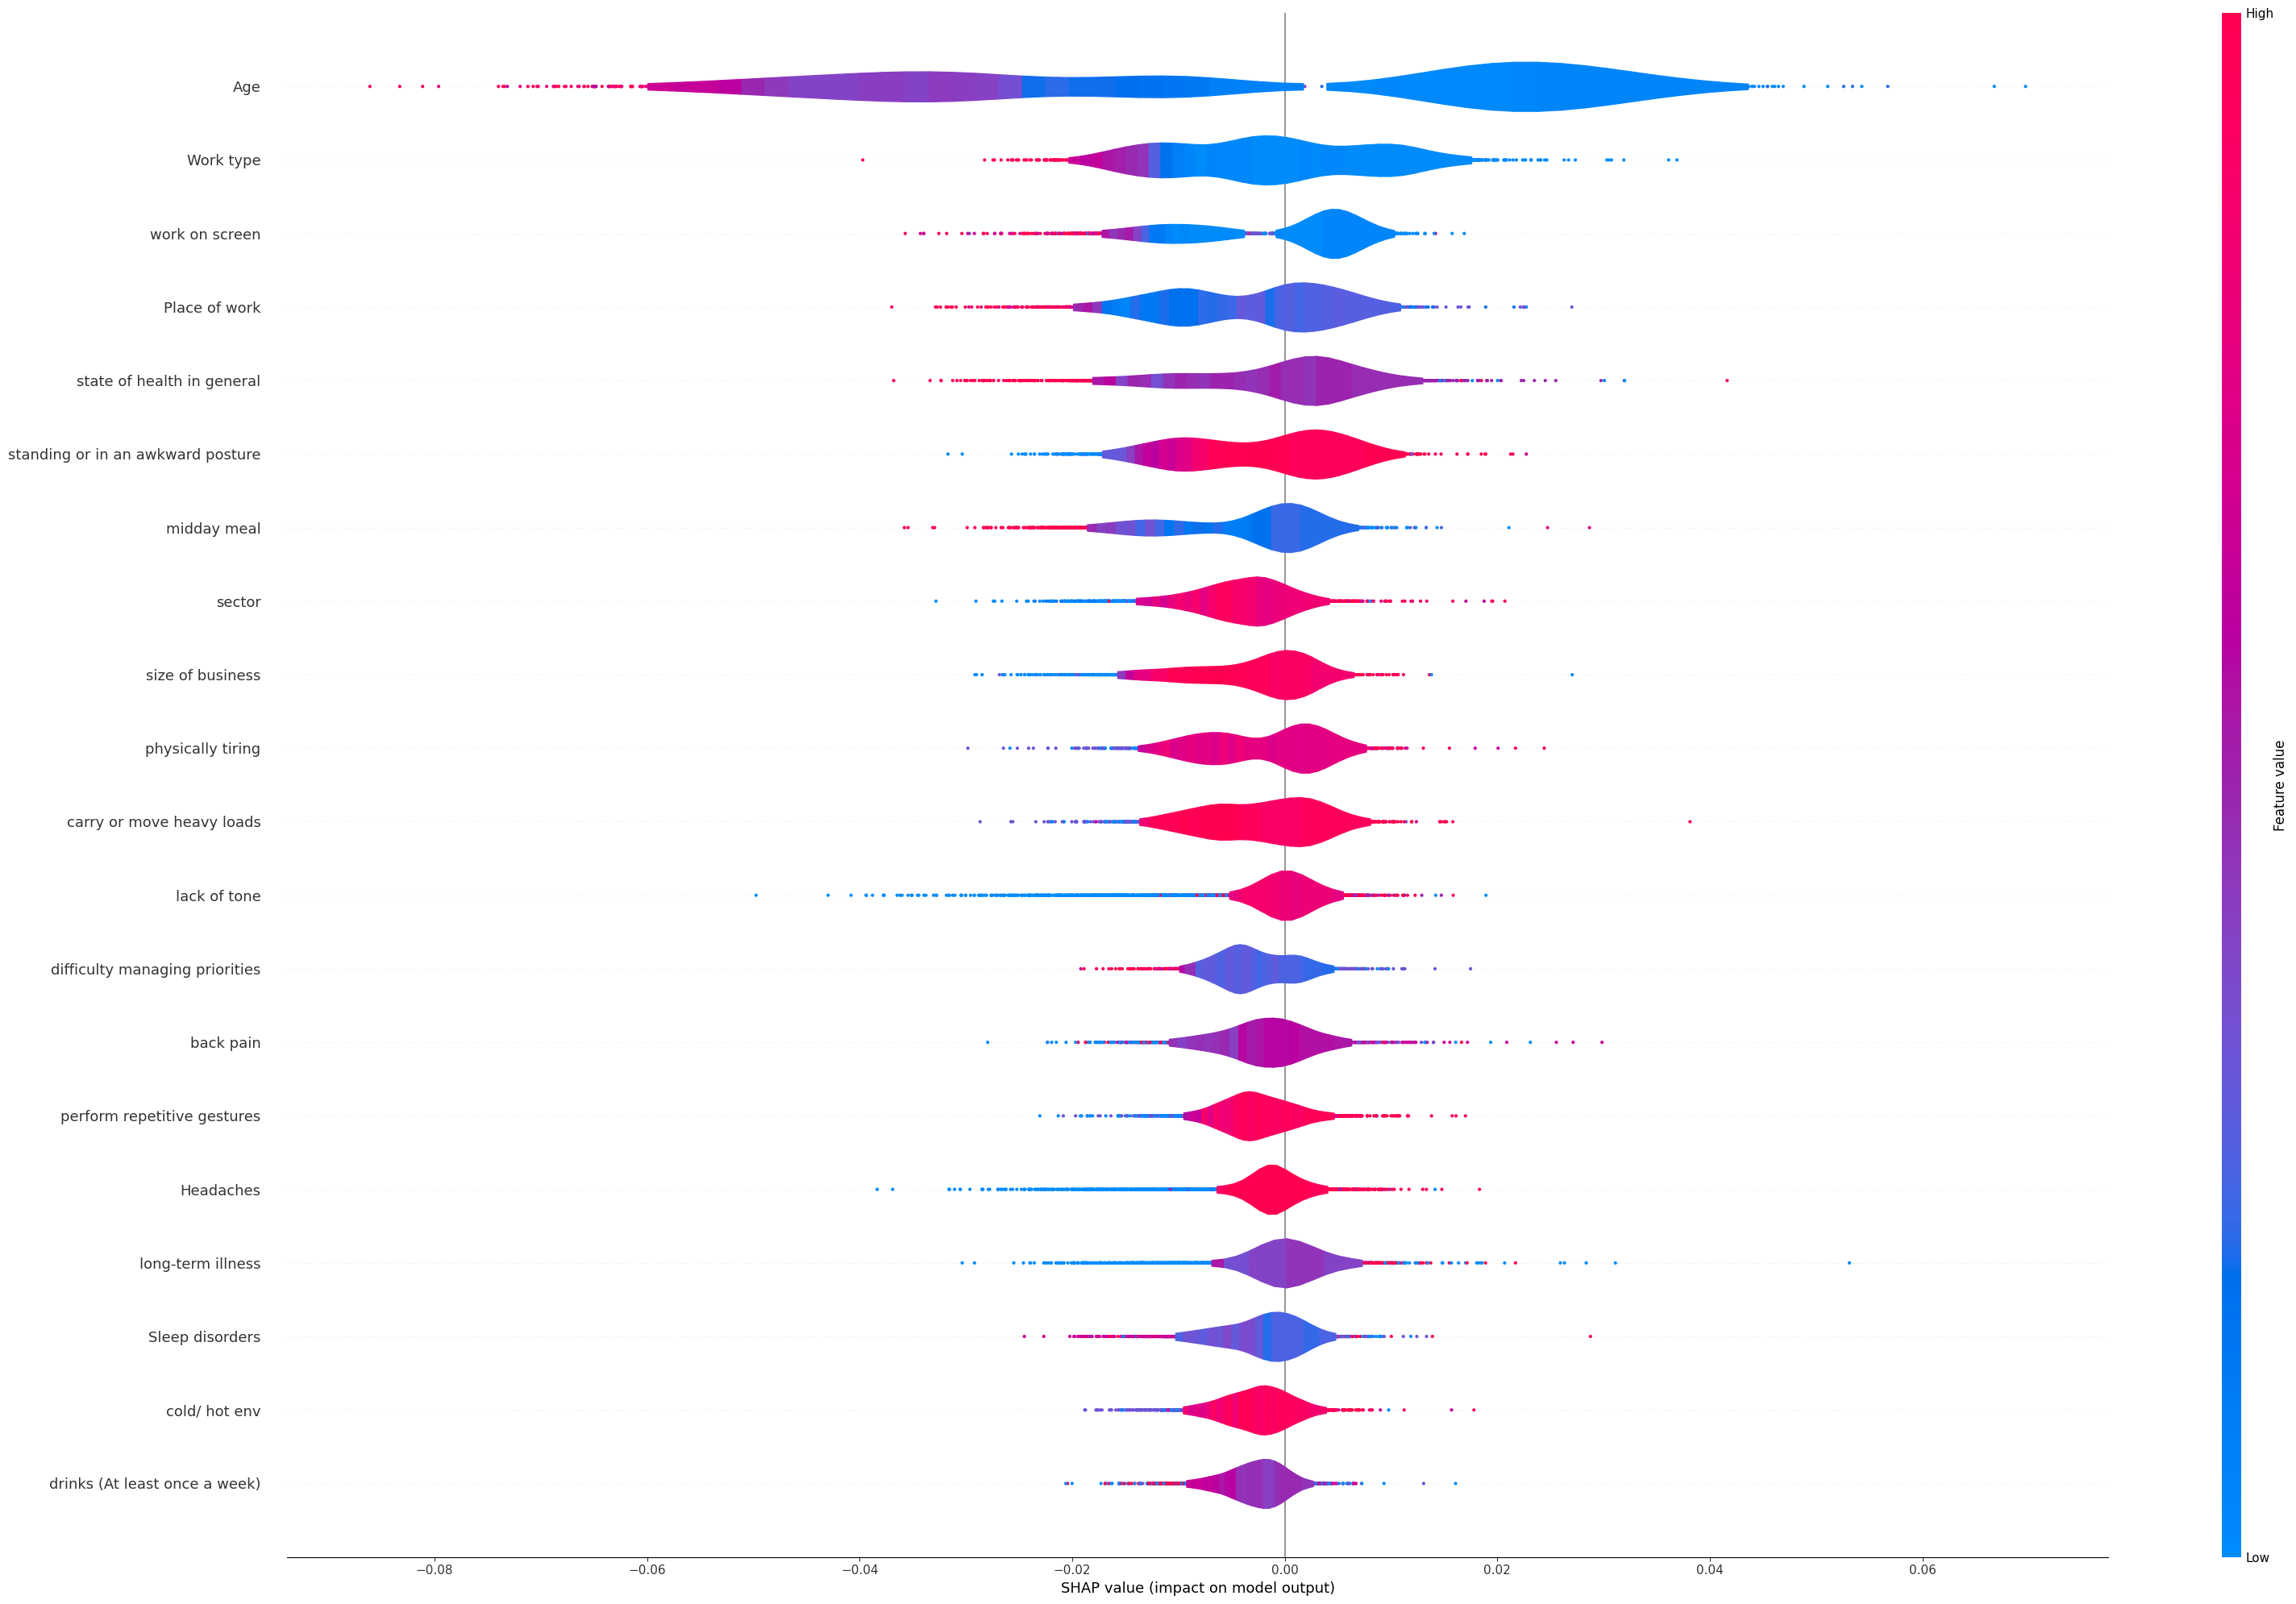

In [21]:
shap.summary_plot(shap_values_all[...,1], X_test, plot_type="violin", plot_size=(32,20), show=False)
plt.savefig('outputs/02_SHAP/shap_summary_plot_violin_all.png', bbox_inches='tight')
plt.show()

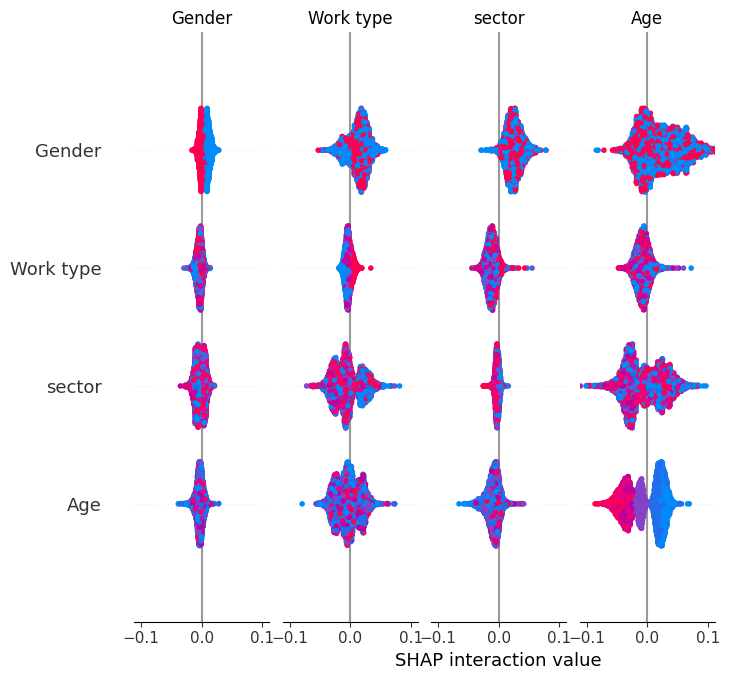

In [22]:
# get the most important feature

shap.summary_plot(shap_values_all, X_test, plot_type="bar", plot_size=(32,20), show=False)
plt.savefig('outputs/02_SHAP/shap_summary_plot_bar_interaction_all.png', bbox_inches='tight')
plt.show()

### XGBoost
max_depth = 3

In [23]:
# train a model with single tree
Xd = xgboost.XGBClassifier(Objective="binary:logistic")
Xd.fit(X_train, y_train)
print("Model error =", np.linalg.norm(y - Xd.predict(X)))

Xd.predict_proba(X_test)[0]

Model error = 129.71892691508052


array([0.7799601 , 0.09721874, 0.08496477, 0.03785635], dtype=float32)

In [24]:
# Calculate model accuracy and F1 score

y_pred = Xd.predict(X_test)
y_pred_proba = Xd.predict_proba(X_test)

print(f"F1 Score: {f1_score(y_test, y_pred, average='macro')}")
print(f"Accuracy of test: {accuracy_score(y_test, y_pred)}")

F1 Score: 0.324965766908625
Accuracy of test: 0.6779259896729777


In [25]:
explainer = shap.Explainer(Xd)
shap_values = explainer(X_test)

print(shap_values.shape)

(4648, 66, 4)


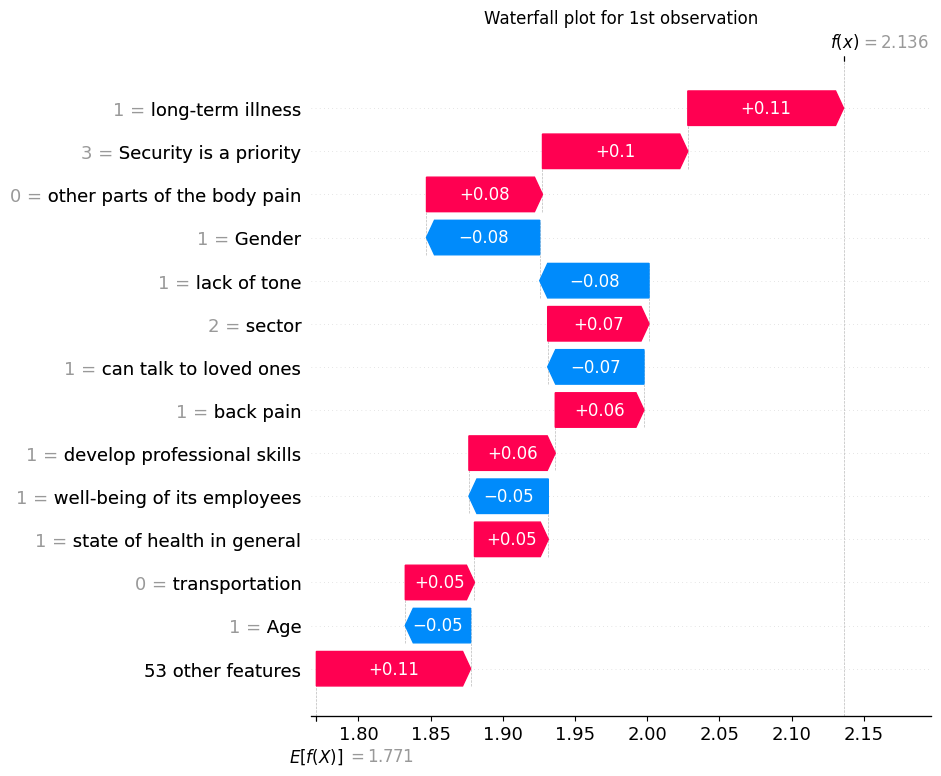

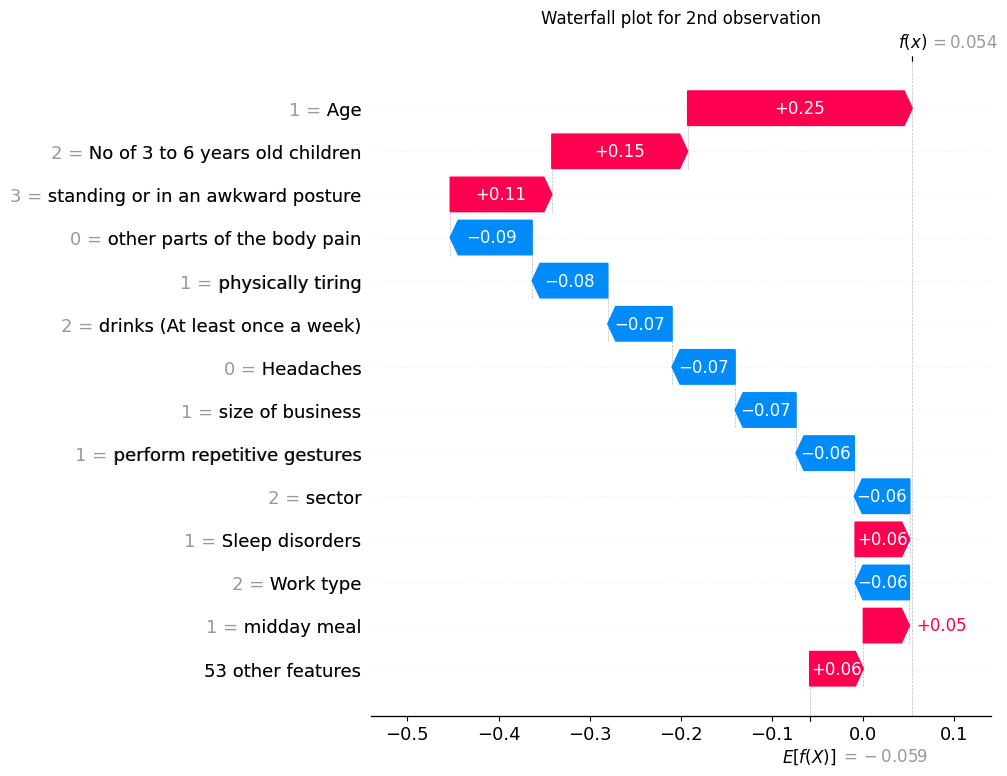

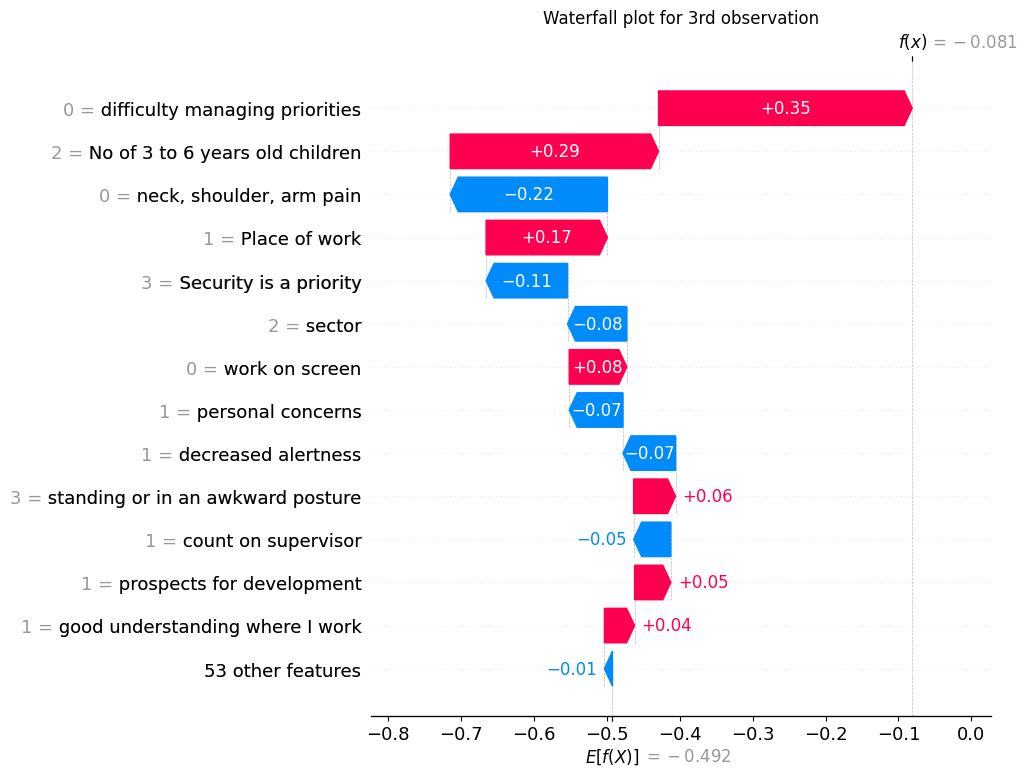

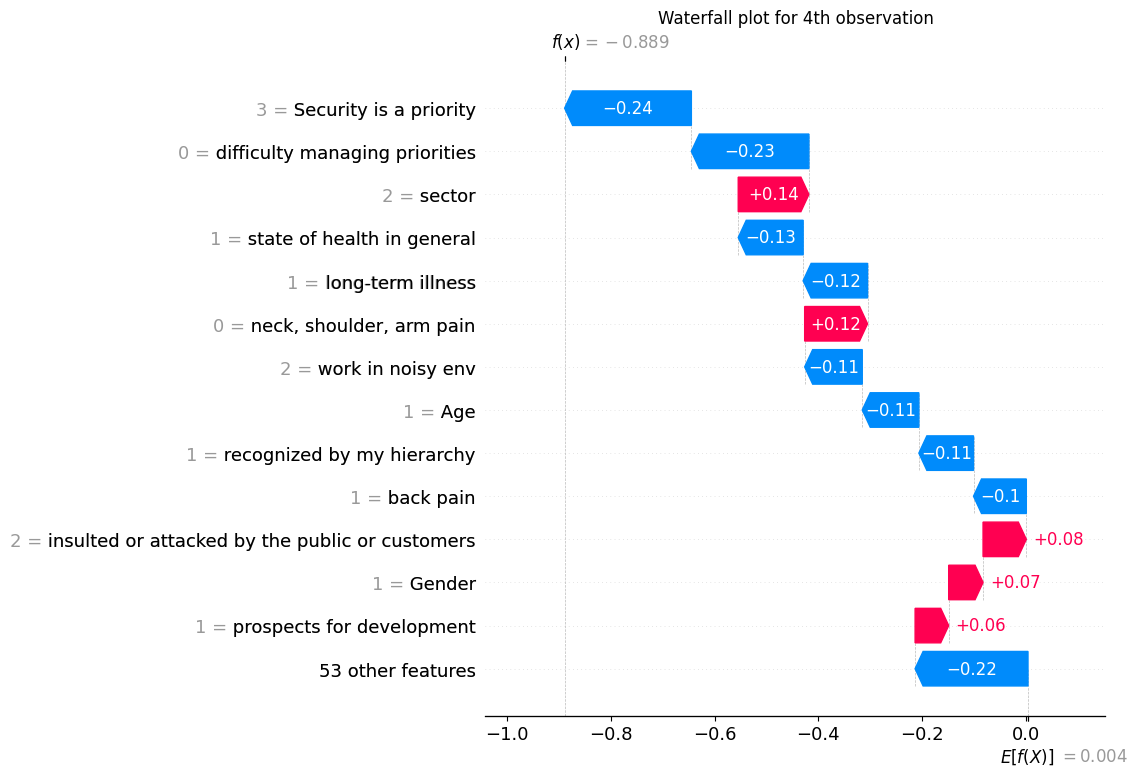

In [26]:
# waterfall plot for first observation
shap.plots.waterfall(shap_values[0,:,0], max_display=14, show=False)
plt.title("Waterfall plot for 1st observation")
plt.savefig('outputs/02_SHAP/3_waterfall_plot_1.png', bbox_inches='tight')
plt.show()

# waterfall plot for 2nd observation
plt.title("Waterfall plot for 2nd observation")
shap.plots.waterfall(shap_values[0,:,1], max_display=14, show=False)
plt.savefig('outputs/02_SHAP/3_waterfall_plot_2.png', bbox_inches='tight')
plt.show()

# waterfall plot for 3rd observation
plt.title("Waterfall plot for 3rd observation")
shap.plots.waterfall(shap_values[0,:,2], max_display=14, show=False)
plt.savefig('outputs/02_SHAP/3_waterfall_plot_3.png', bbox_inches='tight')
plt.show()

# waterfall plot for 4th observation
plt.title("Waterfall plot for 4th observation")
shap.plots.waterfall(shap_values[0,:,3], max_display=14, show=False)
plt.savefig('outputs/02_SHAP/3_waterfall_plot_4.png', bbox_inches='tight')
plt.show()

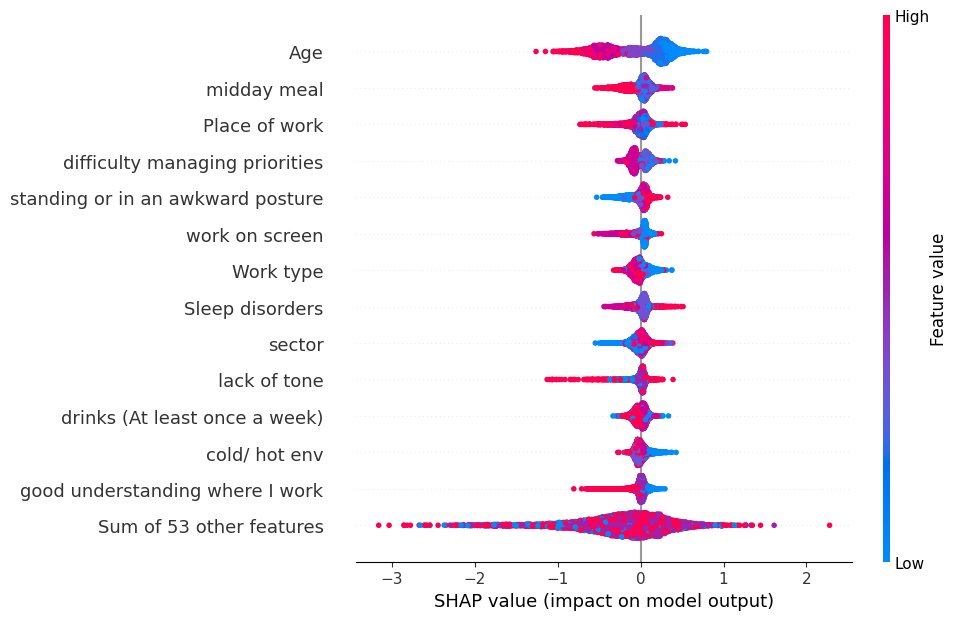

In [27]:
"""
To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample.
The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution
of the impacts each feature has on the model output. The color represents the feature value (red high, blue low).
"""
shap.plots.beeswarm(shap_values[:,:,1], max_display=14, show=False)
plt.savefig('outputs/02_SHAP/shap_beeswarm_plot_xg_4.png', bbox_inches='tight')
plt.show()

In [28]:
# train a model with single tree
Xd = xgboost.DMatrix(X, label=y)
model = xgboost.train({"eta": 1, "max_depth": 3, "base_score": 0, "lambda": 0}, Xd, 1)

print("Model error =", np.linalg.norm(y - model.predict(Xd)))
print(model.get_dump(with_stats=True)[0])

Model error = 157.82918
0:[state of health in general<2] yes=1,no=2,missing=2,gain=1462.28223,cover=23239
	1:[back pain<2] yes=3,no=4,missing=4,gain=192.125488,cover=16147
		3:[sleeping pills, anxiolytics or anti-depressants<1] yes=7,no=8,missing=8,gain=100.022461,cover=11948
			7:leaf=0.417810082,cover=11005
			8:leaf=0.757157981,cover=943
		4:[carry or move heavy loads<1] yes=9,no=10,missing=10,gain=38.633667,cover=4199
			9:leaf=0.88916254,cover=812
			10:leaf=0.646294653,cover=3387
	2:[long-term illness<1] yes=5,no=6,missing=6,gain=527.570312,cover=7092
		5:[state of health in general<3] yes=11,no=12,missing=12,gain=125.715332,cover=2943
			11:leaf=1.26162791,cover=2236
			12:leaf=1.74540317,cover=707
		6:[Disabilities<1] yes=13,no=14,missing=14,gain=117.577637,cover=4149
			13:leaf=1.39696968,cover=330
			14:leaf=0.774810135,cover=3819



In [29]:
pred = model.predict(Xd, output_margin=True)

explainer = shap.TreeExplainer(model)
explanation = explainer(Xd)
shap_values = explanation.values

# make sure the SHAP values add up to marginal predictions
np.abs(shap_values.sum(axis=1) + explanation.base_values - pred).max()

1.1920929e-07

In [30]:
st = time.time()
clustering = shap.utils.hclust(X, y)
et = time.time()
print(time_e(st, et, "Clustering"))

67it [00:50,  1.00s/it]                        

Elapsed time to compute Clustering: 0 minutes and 51 seconds


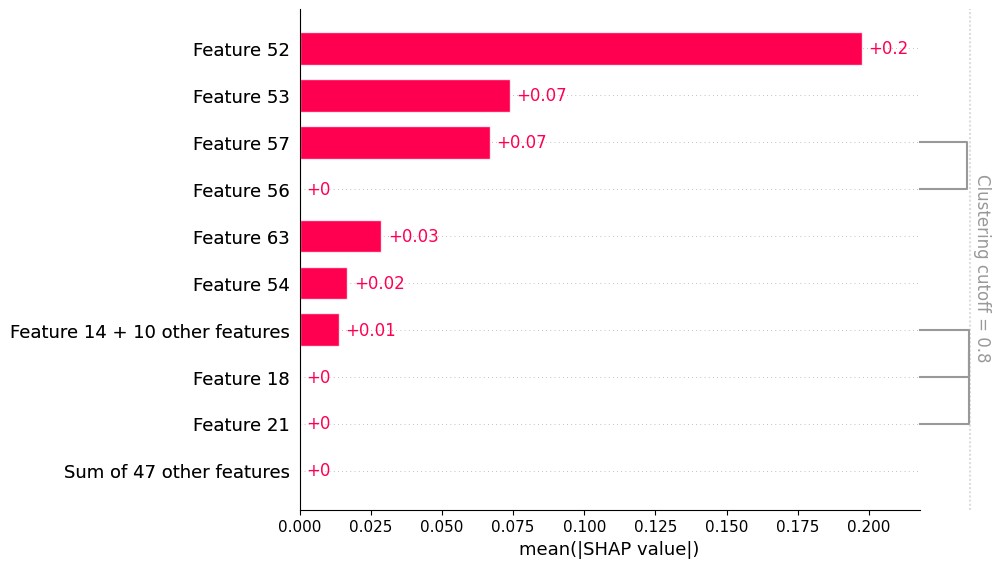

In [31]:
shap.plots.bar(explanation, clustering=clustering, clustering_cutoff=0.8, show=False)
plt.savefig('outputs/02_SHAP/shap_cluster_md_3.png', bbox_inches='tight')
plt.show()

### XGBoost

max_depth = 4

In [32]:
# train a model with single tree
Xd = xgboost.XGBClassifier(Objective="binary:logistic", max_depth=4)
Xd.fit(X_train, y_train)
print("Model error =", np.linalg.norm(y - Xd.predict(X)))

Xd.predict_proba(X_test)[0]

Model error = 169.8558212131689


array([0.662029  , 0.1573902 , 0.08619573, 0.09438506], dtype=float32)

In [33]:
# Calculate model accuracy and F1 score

y_pred = Xd.predict(X_test)
y_pred_proba = Xd.predict_proba(X_test)

print(f"F1 Score: {f1_score(y_test, y_pred, average='macro')}")
print(f"Accuracy of test: {accuracy_score(y_test, y_pred)}")

F1 Score: 0.3067318182215242
Accuracy of test: 0.6809380378657487


In [34]:
explainer = shap.Explainer(Xd)
shap_values = explainer(X_test)

print(shap_values.shape)

(4648, 66, 4)


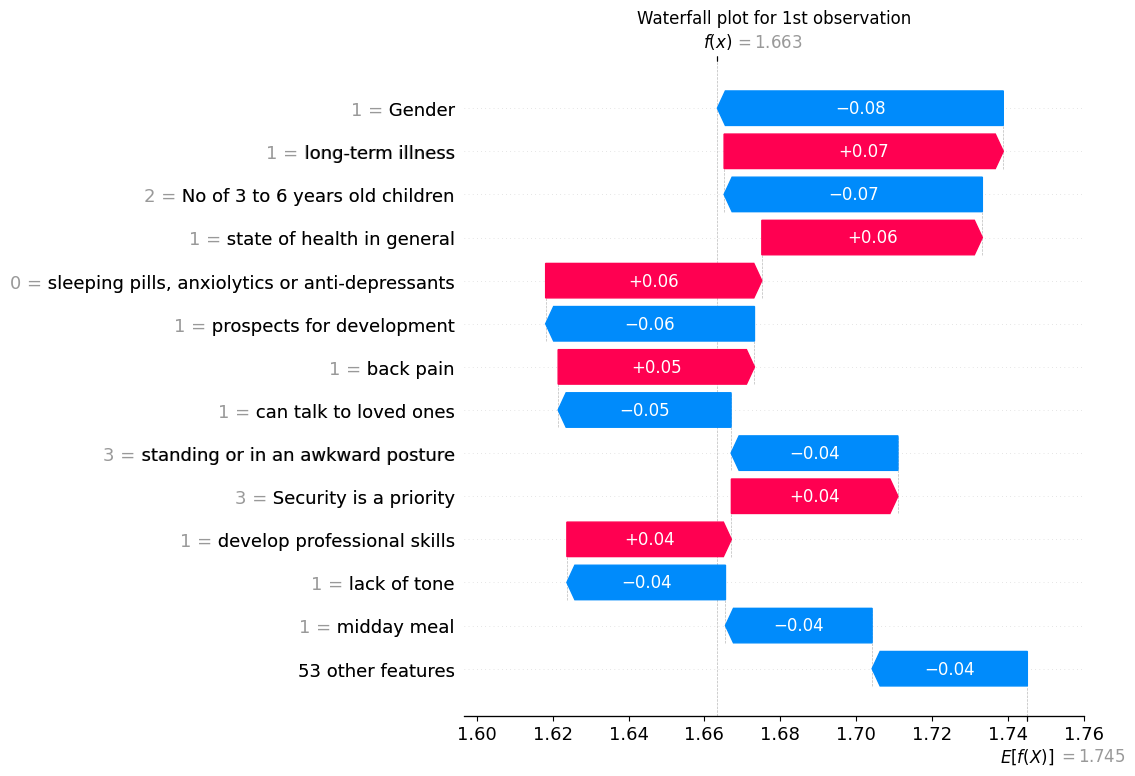

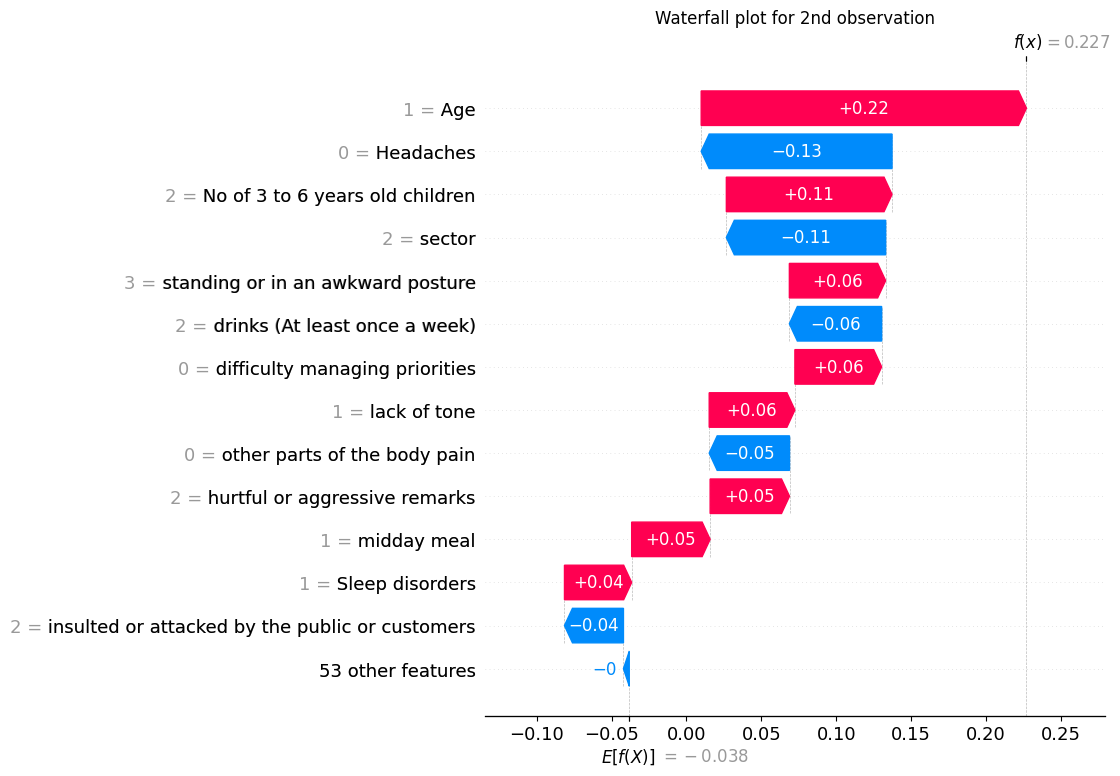

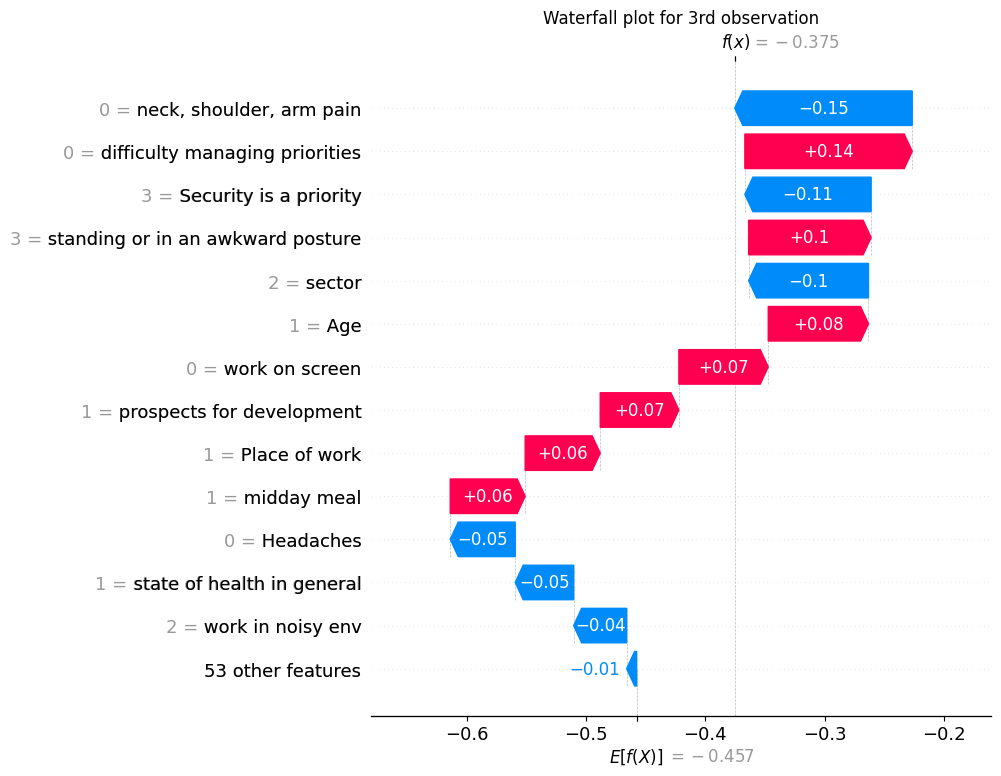

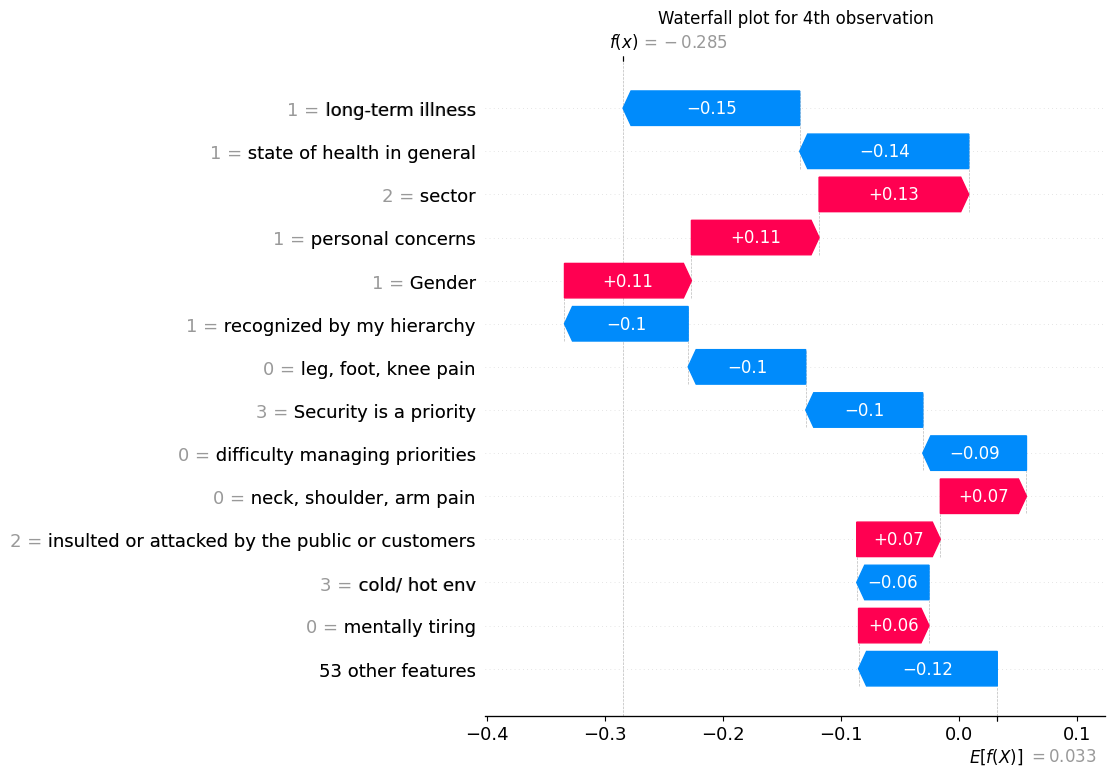

In [35]:
# waterfall plot for first observation
shap.plots.waterfall(shap_values[0,:,0], max_display=14, show=False)
plt.title("Waterfall plot for 1st observation")
plt.savefig('outputs/02_SHAP/4_waterfall_plot_1.png', bbox_inches='tight')
plt.show()

# waterfall plot for 2nd observation
plt.title("Waterfall plot for 2nd observation")
shap.plots.waterfall(shap_values[0,:,1], max_display=14, show=False)
plt.savefig('outputs/02_SHAP/4_waterfall_plot_2.png', bbox_inches='tight')
plt.show()

# waterfall plot for 3rd observation
plt.title("Waterfall plot for 3rd observation")
shap.plots.waterfall(shap_values[0,:,2], max_display=14, show=False)
plt.savefig('outputs/02_SHAP/4_waterfall_plot_3.png', bbox_inches='tight')
plt.show()

# waterfall plot for 4th observation
plt.title("Waterfall plot for 4th observation")
shap.plots.waterfall(shap_values[0,:,3], max_display=14, show=False)
plt.savefig('outputs/02_SHAP/4_waterfall_plot_4.png', bbox_inches='tight')
plt.show()

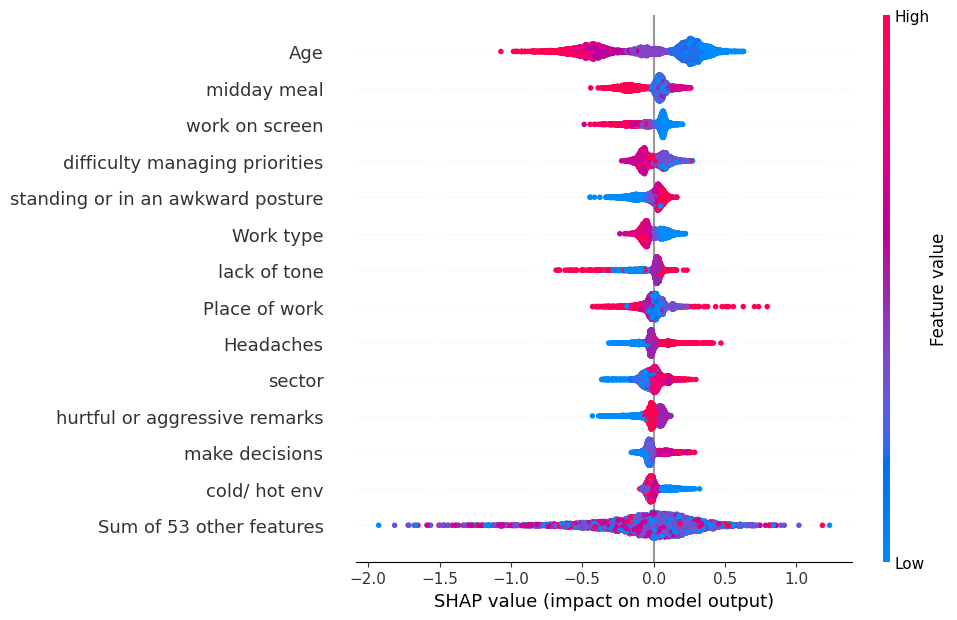

In [36]:
shap.plots.beeswarm(shap_values[:,:,1], max_display=14, show=False)
plt.savefig('outputs/02_SHAP/shap_beeswarm_plot_xg_4.png', bbox_inches='tight')
plt.show()

In [37]:
# train a model with single tree
Xd = xgboost.DMatrix(X, label=y) 
model = xgboost.train({"eta": 1, "max_depth": 4, "base_score": 0, "lambda": 0}, Xd, 1)
baseline_error = np.linalg.norm(y - model.predict(Xd))
print("Baseline Model error =", baseline_error)
print(model.get_dump(with_stats=True)[0])

Baseline Model error = 156.6296
0:[state of health in general<2] yes=1,no=2,missing=2,gain=1462.28223,cover=23239
	1:[back pain<2] yes=3,no=4,missing=4,gain=192.125488,cover=16147
		3:[sleeping pills, anxiolytics or anti-depressants<1] yes=7,no=8,missing=8,gain=100.022461,cover=11948
			7:[prospects for development<1] yes=15,no=16,missing=16,gain=72.7181396,cover=11005
				15:leaf=0.332826167,cover=5258
				16:leaf=0.495562911,cover=5747
			8:[recognized by my hierarchy<3] yes=17,no=18,missing=18,gain=44.4741211,cover=943
				17:leaf=0.669543803,cover=811
				18:leaf=1.2954545,cover=132
		4:[carry or move heavy loads<1] yes=9,no=10,missing=10,gain=38.633667,cover=4199
			9:[long-term illness<1] yes=19,no=20,missing=20,gain=26.9442749,cover=812
				19:leaf=1.30075192,cover=133
				20:leaf=0.808541954,cover=679
			10:[sleeping pills, anxiolytics or anti-depressants<3] yes=21,no=22,missing=22,gain=29.3518066,cover=3387
				21:leaf=0.623474181,cover=3195
				22:leaf=1.02604163,cover=192
	2

In [38]:
# Calculate model accuracy and F1 score

y_pred = model.predict(Xd)
y_pred = [1 if i > 0.5 else 0 for i in y_pred] # convert to binary
print(f"F1 Score {f1_score(y, y_pred, average='macro')}")
print(f"Accuracy {accuracy_score(y, y_pred)}")

F1 Score 0.20957362008465225
Accuracy 0.4292783682602522


In [39]:
pred = model.predict(Xd, output_margin=True)

explainer = shap.TreeExplainer(model)
explanation = explainer(Xd)

shap_values = explanation.values
# make sure the SHAP values add up to marginal predictions
np.abs(shap_values.sum(axis=1) + explanation.base_values - pred).max()

3.5762787e-07

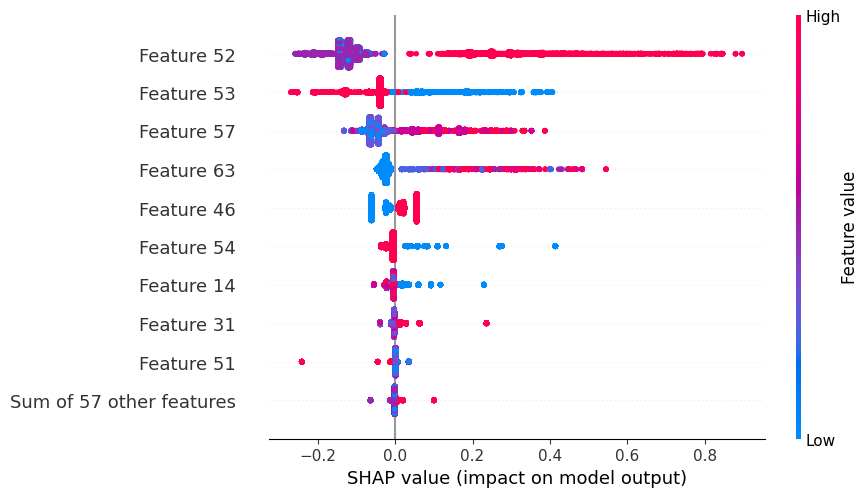

In [40]:
shap.plots.beeswarm(explanation, show=False) # plot the SHAP values
plt.figsize=(32,12)
plt.savefig('outputs/02_SHAP/shap_beeswarm_plot_xg_4.png', bbox_inches='tight')
plt.show()

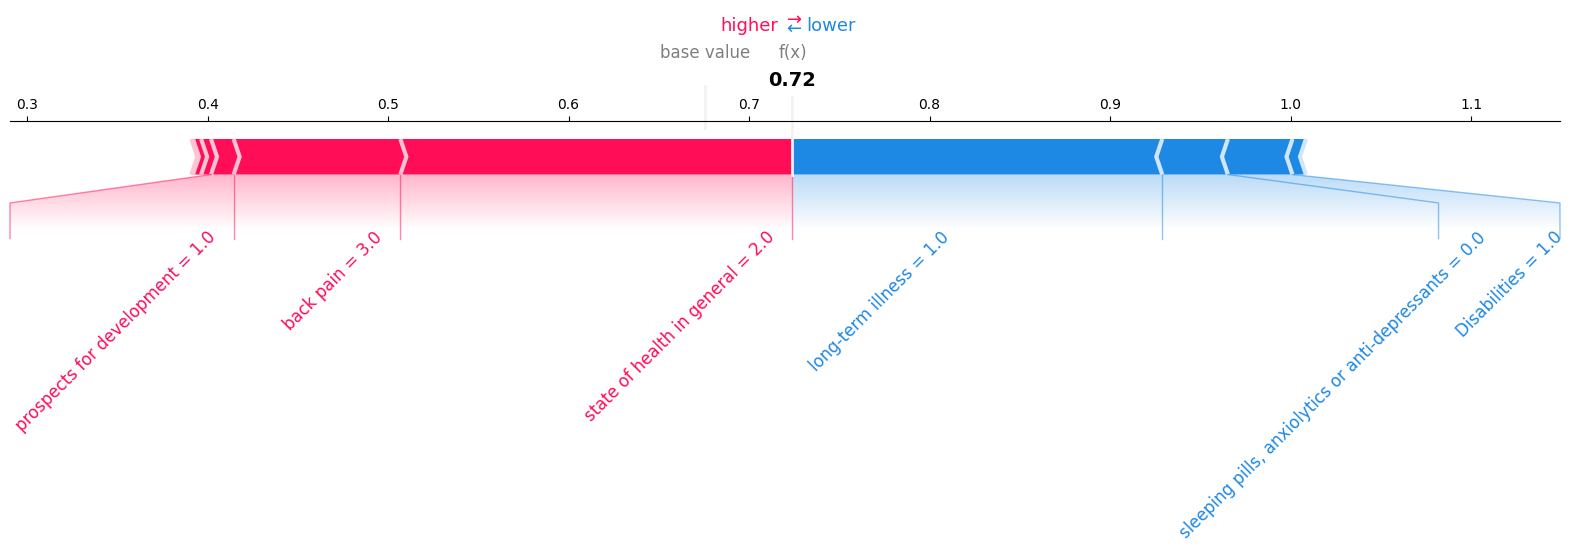

In [41]:
shap.force_plot(explanation.base_values[0], shap_values[0,:], X.iloc[0,:], text_rotation=45, matplotlib=True, show= False) # shows the shap values for the second prediction
plt.savefig('outputs/02_SHAP/shap_force_plot_xg_4.png', bbox_inches='tight')
plt.show()

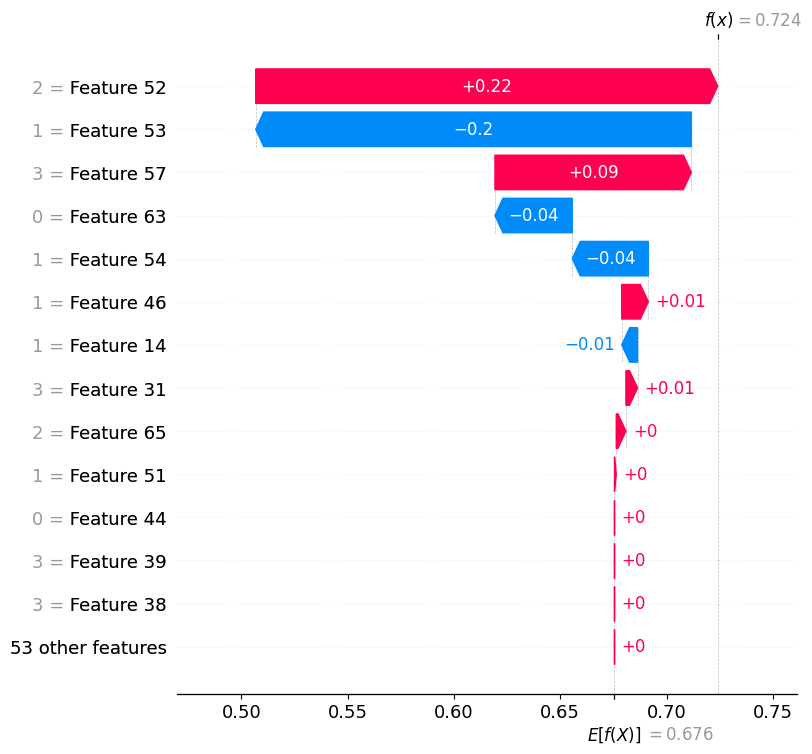

In [42]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
shap.plots.waterfall(explanation[0,:], max_display=14, show=False)
plt.figsize=(32,18)
plt.savefig('outputs/02_SHAP/shap_waterfall_plot_xg_4.png', bbox_inches='tight')
plt.show()

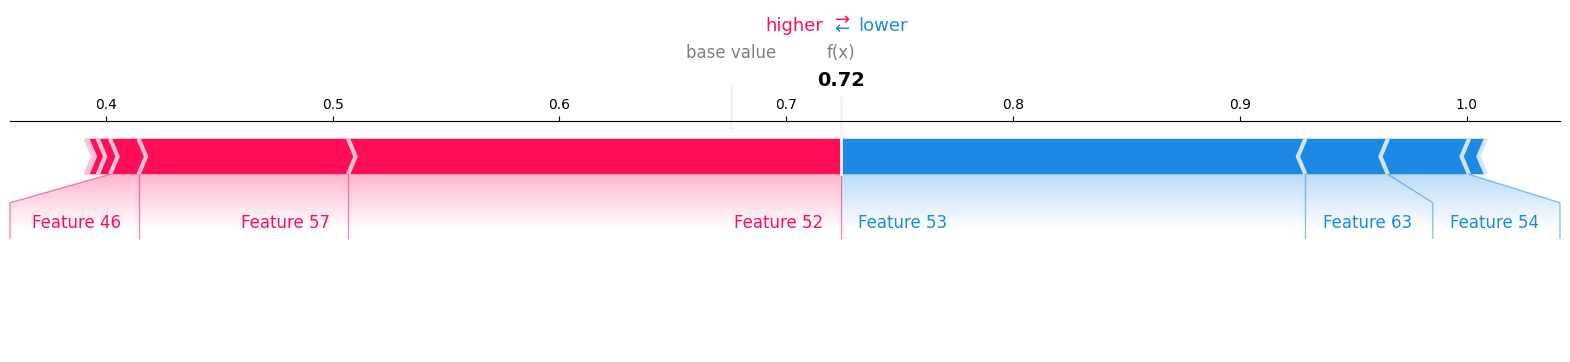

In [43]:
shap.plots.force(explainer.expected_value, shap_values[0, ...], show= False, matplotlib=True) # shap_values[0, ...] is the SHAP values for the first instance in the dataset ... is a numpy slice that means "all of the other axes"
plt.savefig('outputs/02_SHAP/shap_force_plot_xg_4_2.png', bbox_inches='tight')
plt.show()

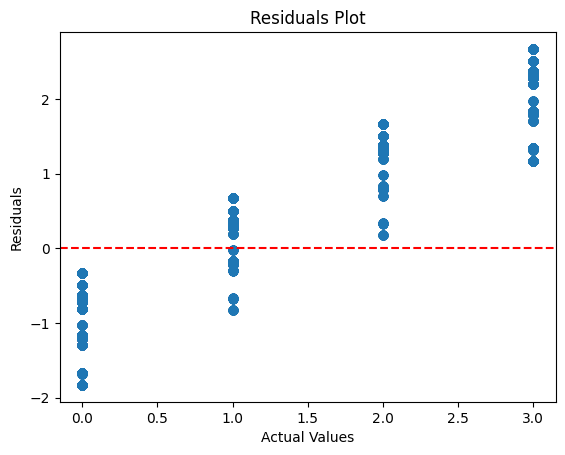

In [44]:
residuals = y - model.predict(Xd)
plt.scatter(y, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')

# save the plot
plt.savefig('outputs/02_SHAP/residuals_plot.png', bbox_inches='tight')
plt.show()

In [45]:
st = time.time()
clustering = shap.utils.hclust(X, y)
et = time.time()
print(time_e(st, et, "Clustering"))

67it [12:19, 14.50s/it]                         

Elapsed time to compute Clustering: 12 minutes and 21 seconds


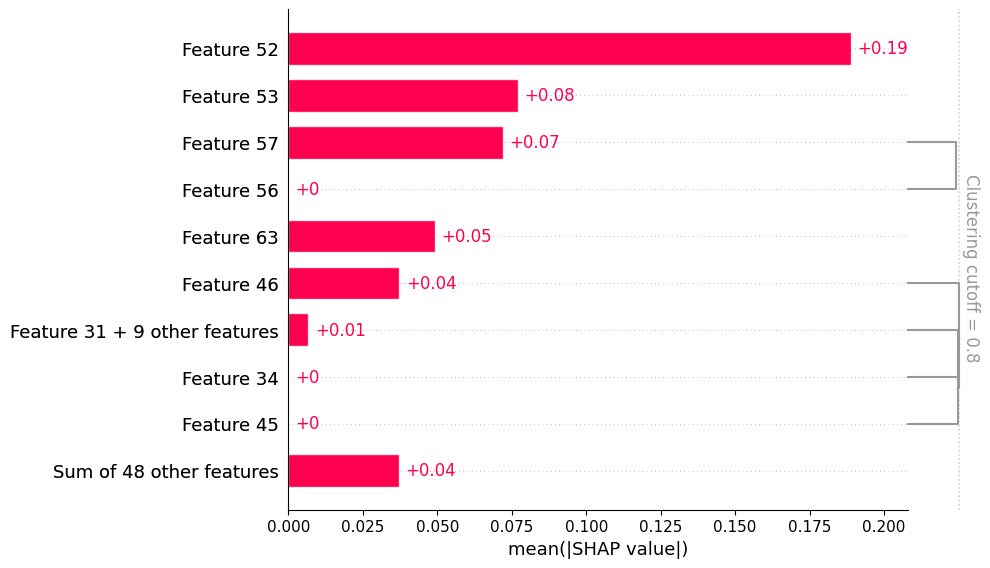

In [46]:
shap.plots.bar(explanation, clustering=clustering, clustering_cutoff=0.8, show=False)
plt.savefig('outputs/02_SHAP/shap_cluster_md_3.png', bbox_inches='tight')
plt.show()

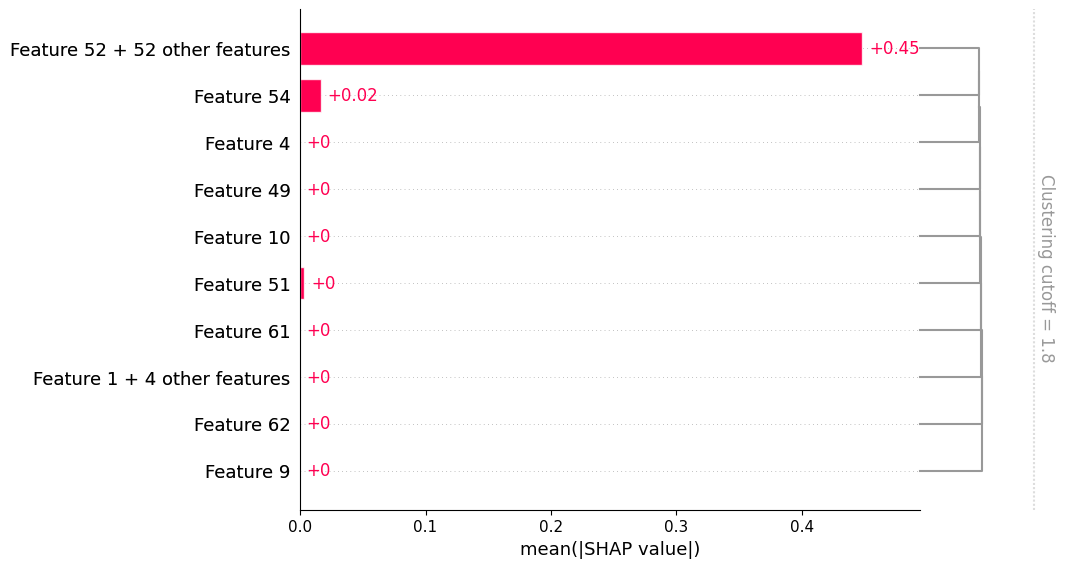

In [47]:
shap.plots.bar(explanation, clustering=clustering, clustering_cutoff=1.8, show=False)
plt.savefig('outputs/02_SHAP/shap_cluster_md_3_1_8.png', bbox_inches='tight')
plt.show()